In [131]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scnrma
import pandas as pd
from harmony import harmonize
from sklearn.metrics.cluster import adjusted_rand_score
import random
from sklearn.metrics import confusion_matrix

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.logging.print_memory_usage()
sc.set_figure_params(dpi=150)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0
Memory usage: current 2.04 GB, difference +0.00 GB


In [1]:
from harmony import harmonize

# P8 glut

## L5 PT adjustment

Looks like we've accidentally thrown out the L5PT cells in Figure 1. Let's go find them. 

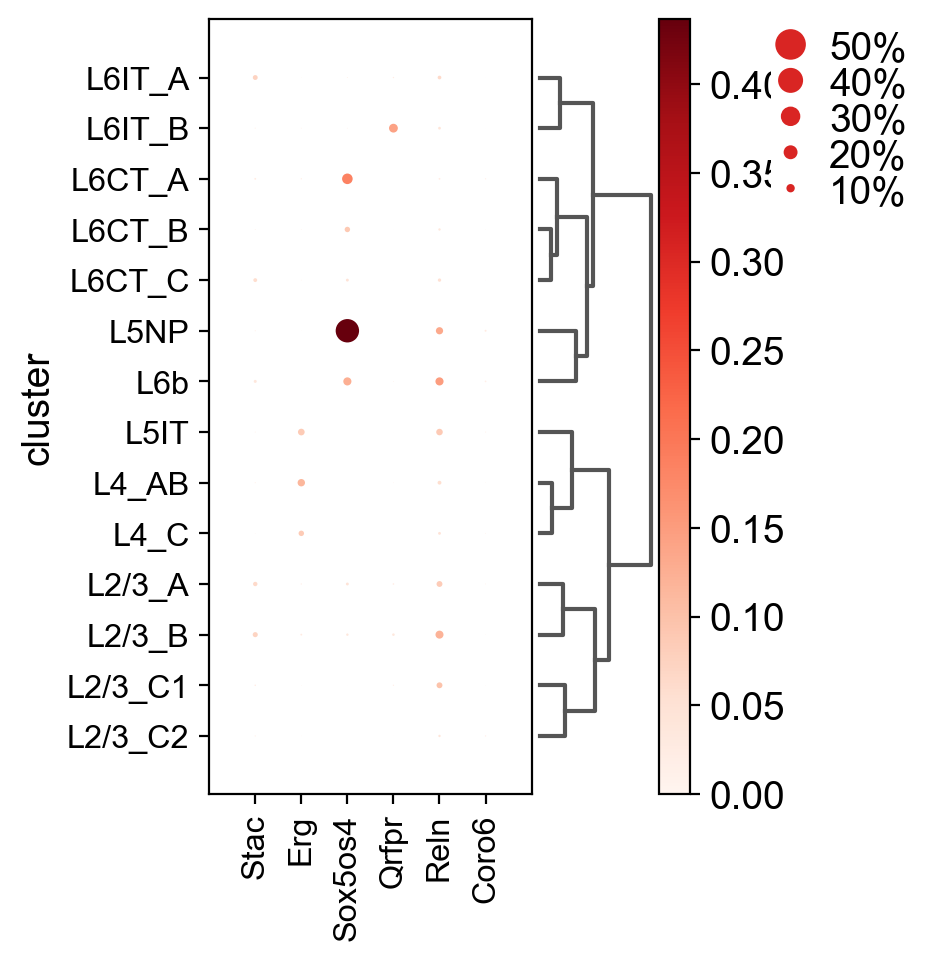

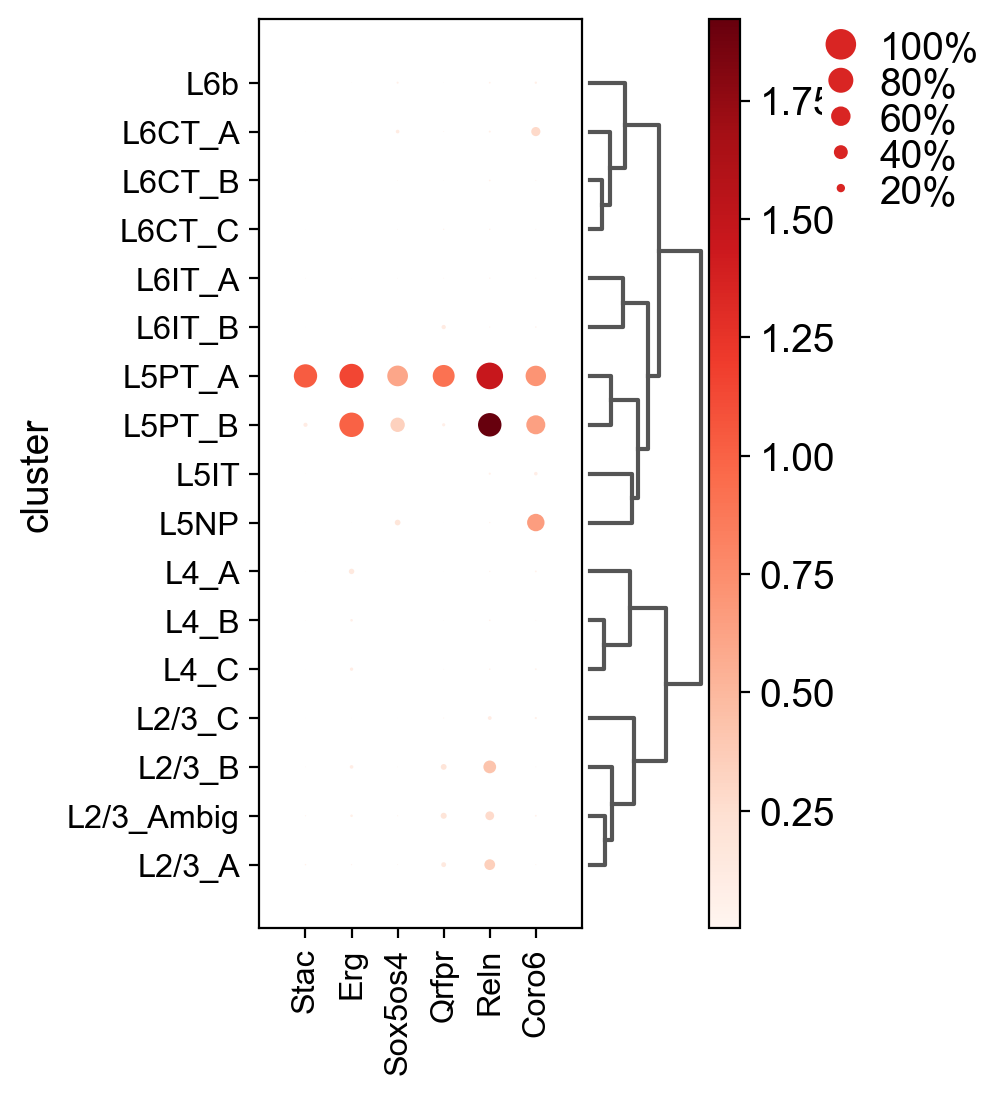

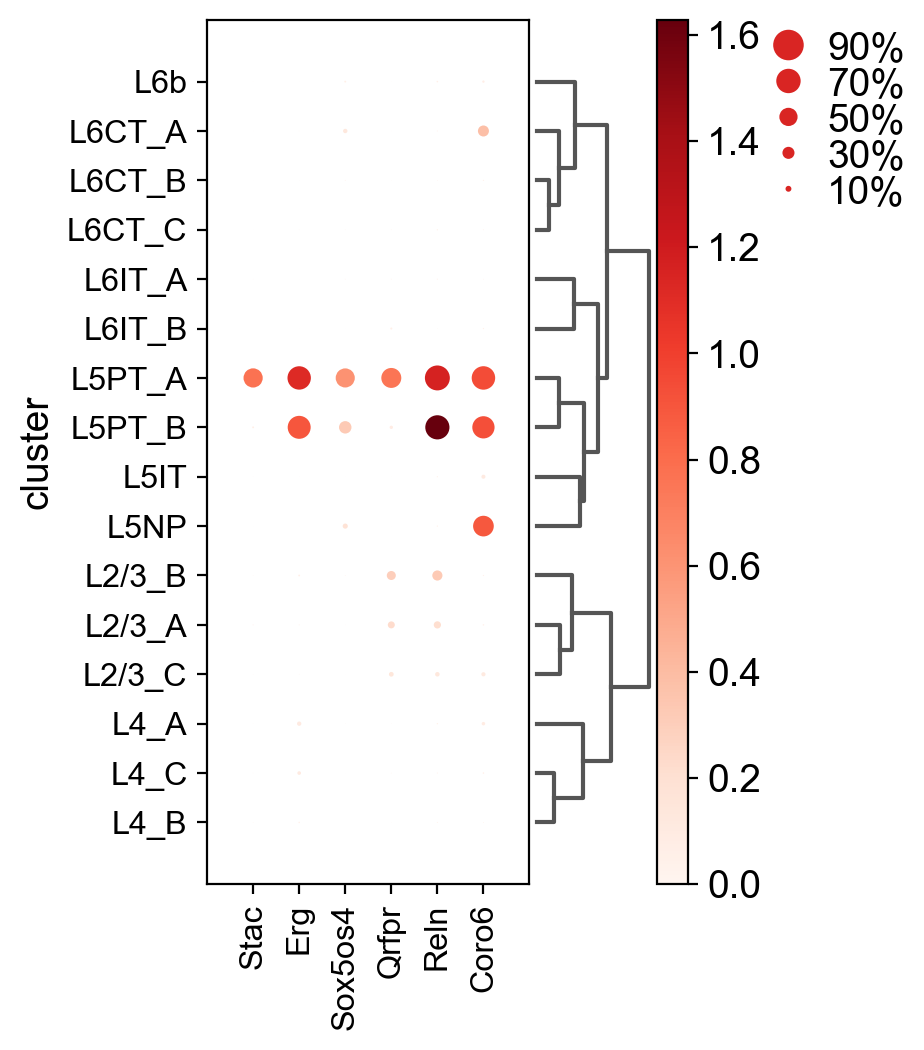

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.0999999999999996, 0.8, 0.2, 0.5, 0.25])

In [124]:
# these are the same in all ages P14-P38
L5PT_markers = ['Stac', 'Erg', 'Sox5os4', 'Qrfpr', 'Reln', 'Coro6']
sc.pl.dotplot(P8_glut, L5PT_markers, groupby='cluster', dendrogram=True)
sc.pl.dotplot(P14_glut, L5PT_markers, groupby='cluster', dendrogram=True)
sc.pl.dotplot(P17_glut, L5PT_markers, groupby='cluster', dendrogram=True)

In [ ]:
#code for savio
adata = sc.read_h5ad('PooledMVC_clusteredPCA.h5ad')
L5PT_markers = ['Stac', 'Erg', 'Sox5os4', 'Qrfpr', 'Reln', 'Coro6']
sc.pl.dotplot(adata, L5PT_markers, groupby='leiden', dendrogram=True, save='_L5PTmarkers.pdf')

In [ ]:
#code for savio
adata = sc.read_h5ad('PooledMVC_clusteredPCA_dubs.h5ad')
C26 = adata[adata.obs.leiden=='26',:]
C26.write_h5ad('C26.h5ad')

In [140]:
C26 = sc.read_h5ad('/path/to/C26.h5ad')

In [179]:
P8_glut_test = P8_glut.concatenate(C26[C26.obs.batch=='P8',:], batch_categories=['P8_glut', 'C26'])

In [180]:
del P8_glut_test.obsp
del P8_glut_test.varm
del P8_glut_test.obsm
del P8_glut_test.uns
P8_glut_test.X = P8_glut_test.raw.X
sc.pp.highly_variable_genes(P8_glut_test, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs
sc.pp.scale(P8_glut_test, max_value=10) #scale
sc.tl.pca(P8_glut_test, svd_solver='arpack') #run PCA

P8_glut_test_CBs = list(P8_glut_test.obs.index)
P8_glut_test_batch = []
for i in range(len(P8_glut_test_CBs)):
    P8_glut_test_batch.append(P8_glut_test_CBs[i][19:25])
    
P8_glut_test.obs['sample'] = P8_glut_test.obs['batch']
P8_glut_test.obs['sample'] = P8_glut_test_batch

#sc.pp.neighbors(P8_glut_test, n_neighbors=25, n_pcs=40) #choose 25 standard for now
bbknn(P8_glut_test, batch_key='sample',neighbors_within_batch=6 ) #6*4~=25
sc.tl.leiden(P8_glut_test)
sc.tl.umap(P8_glut_test)

... storing 'Age' as categorical
... storing 'Class_broad' as categorical
... storing 'cluster' as categorical
... storing 'sample' as categorical
... storing 'subclass' as categorical
... storing 'feature_types' as categorical


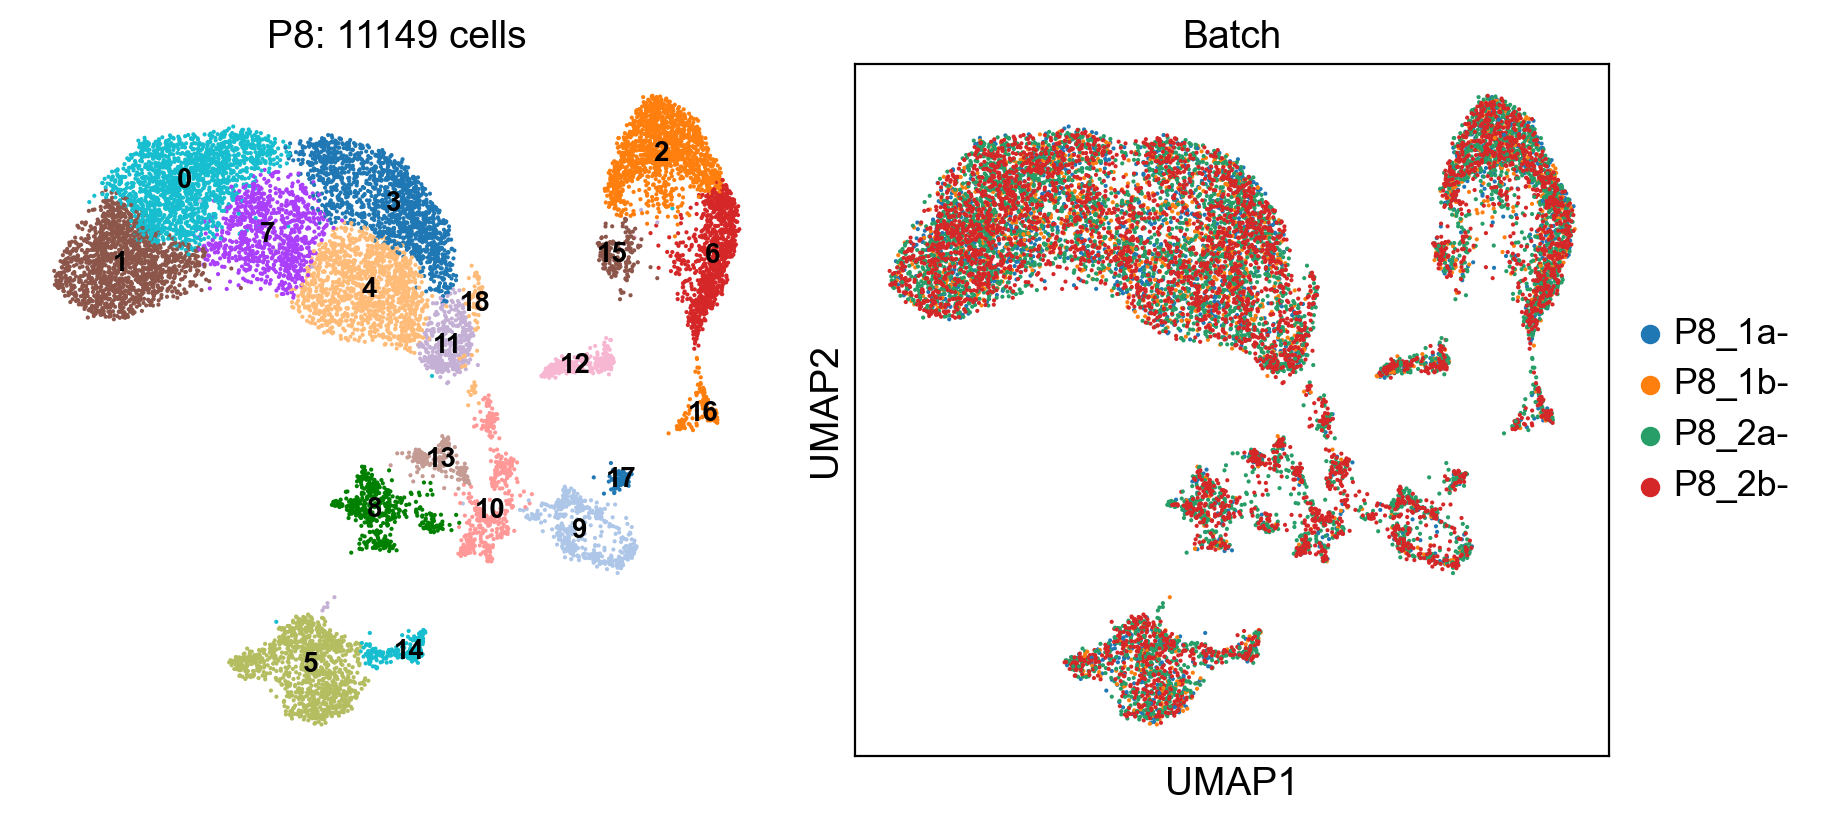

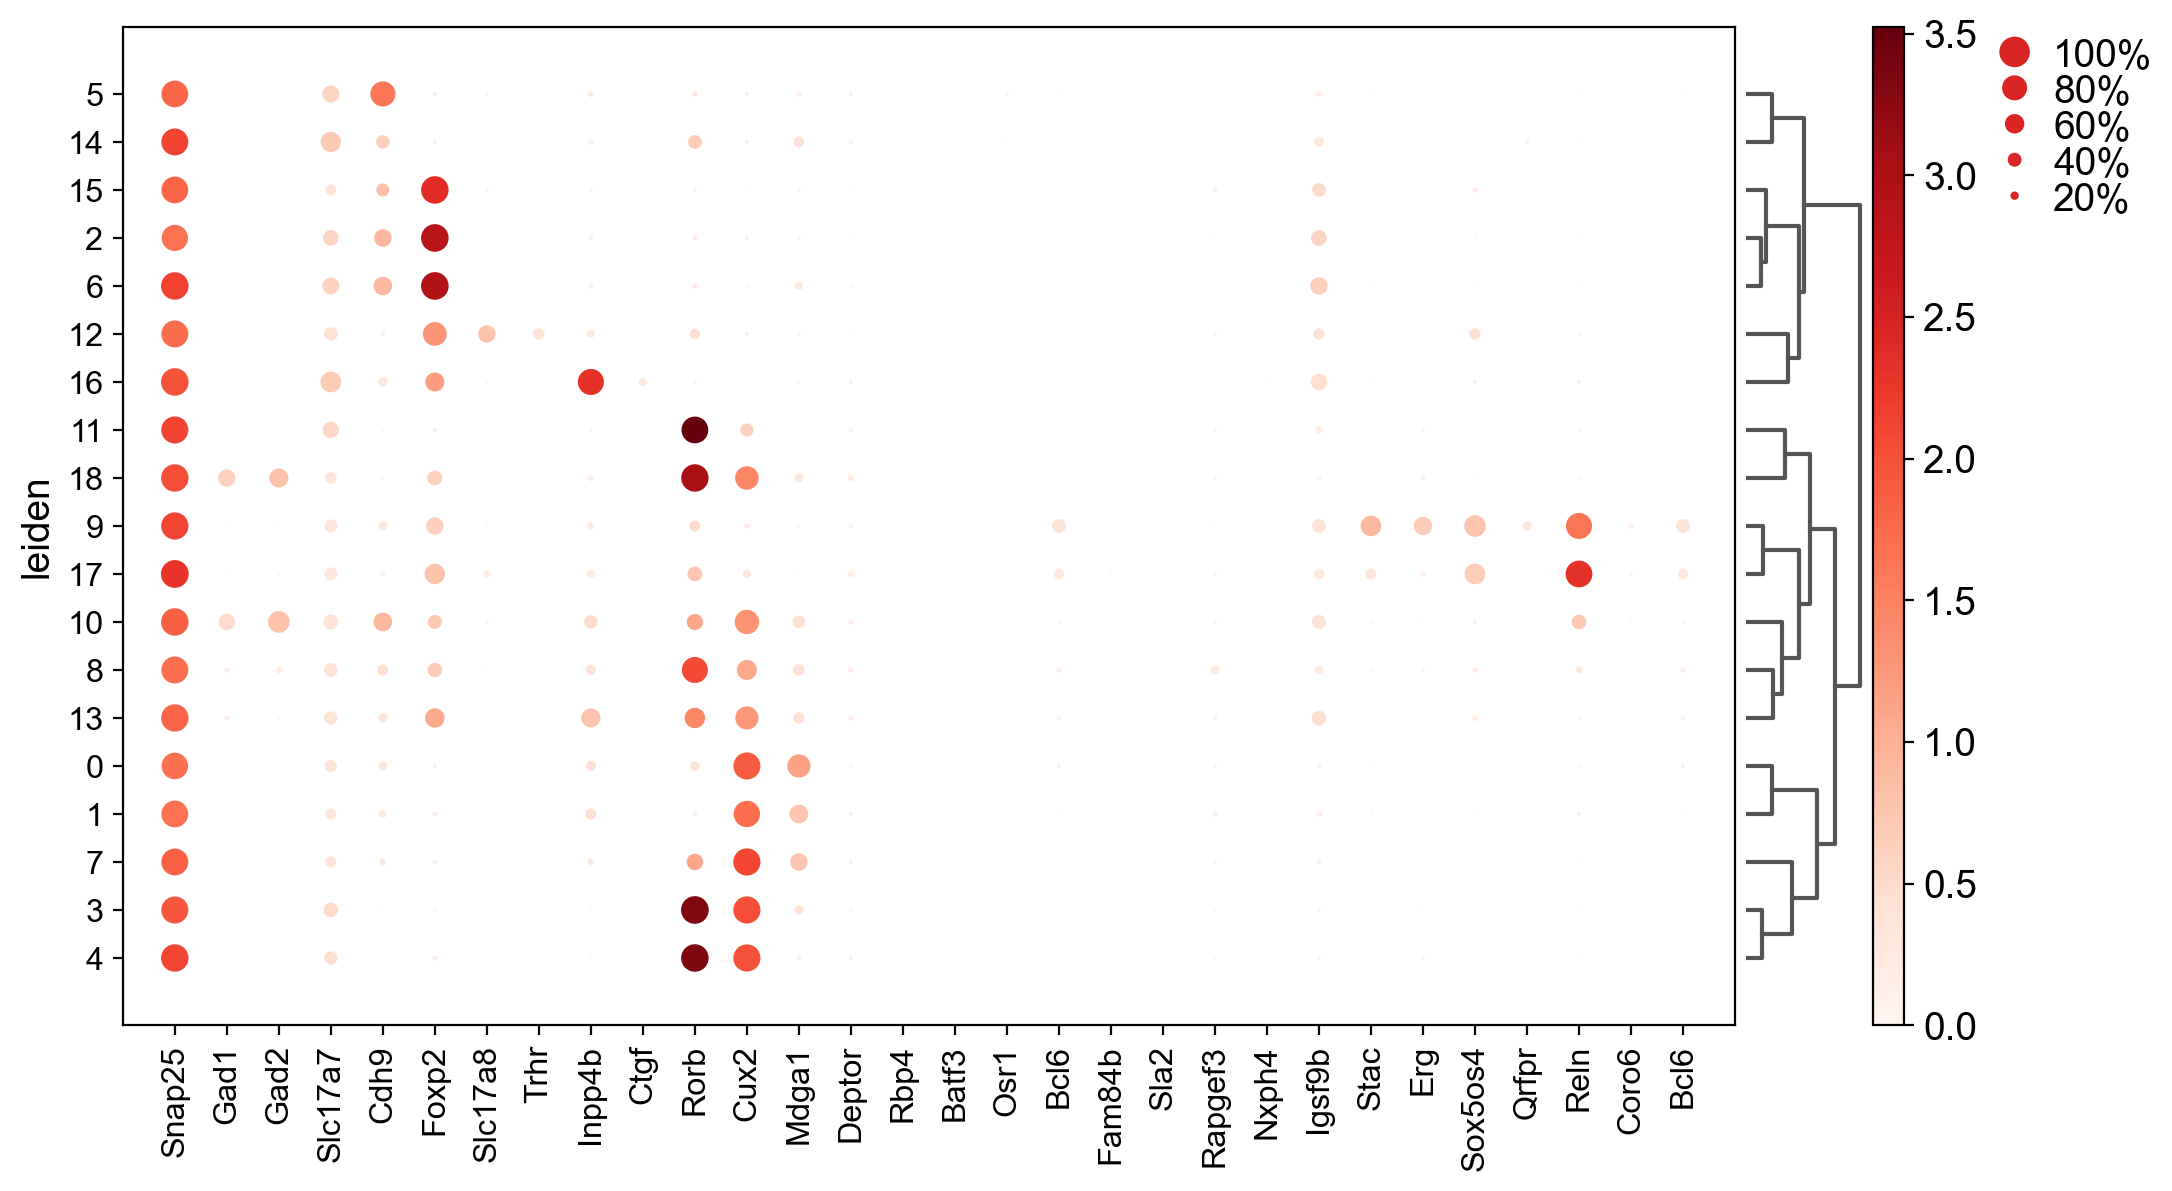

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[10.5, 0.8, 0.2, 0.5, 0.25])

In [181]:
fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)
sc.pl.umap(P8_glut_test, color='leiden', legend_fontsize='10', ax=axs[0], 
           show=False, title='P8: ' + str(P8_glut.shape[0]) + ' cells', frameon=False, 
          palette=('#17becf', '#8c564b', '#ff7f0e', '#1f77b4', 
                  '#ffbb78', '#b5bd61', '#d62728', '#aa40fc', 
                  'green', '#aec7e8', '#ff9896', '#c5b0d5', 
                  '#f7b6d2', '#c49c94'), legend_loc='on data')
sc.pl.umap(P8_glut_test, color='sample', ax=axs[1], show=False, title='Batch')

bias_markers = ['Snap25', 'Gad1', 'Gad2', 'Slc17a7', 
                'Cdh9', 'Foxp2', 'Slc17a8', 'Trhr', 'Inpp4b', 'Ctgf', 'Rorb', 'Cux2', 'Mdga1',
                'Deptor', 'Rbp4', 'Batf3',
               'Osr1',  
               'Bcl6', 'Fam84b', 
                'Sla2', 'Rapgef3',
                'Nxph4', 'Igsf9b']

#bias_pos = [(0,6), (7,15)]
#bias_labels = ['Neuronal', 'Non-Neuronal']
#sc.pl.dotplot(P8_glut, bias_markers, groupby='leiden', dendrogram=True)

sc.pl.dotplot(P8_glut_test, bias_markers + L5PT_markers + ['Bcl6'], 
              groupby='leiden', dendrogram=True)

In [182]:
P8_glut_test = P8_glut_test[P8_glut_test.obs['leiden']!='10',:]
P8_glut_test = P8_glut_test[P8_glut_test.obs['leiden']!='18',:]

In [183]:
P8_glut_test.obs.leiden.values.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '11', '12', '13',
       '14', '15', '16', '17'],
      dtype='object')

Trying to set attribute `.uns` of view, copying.


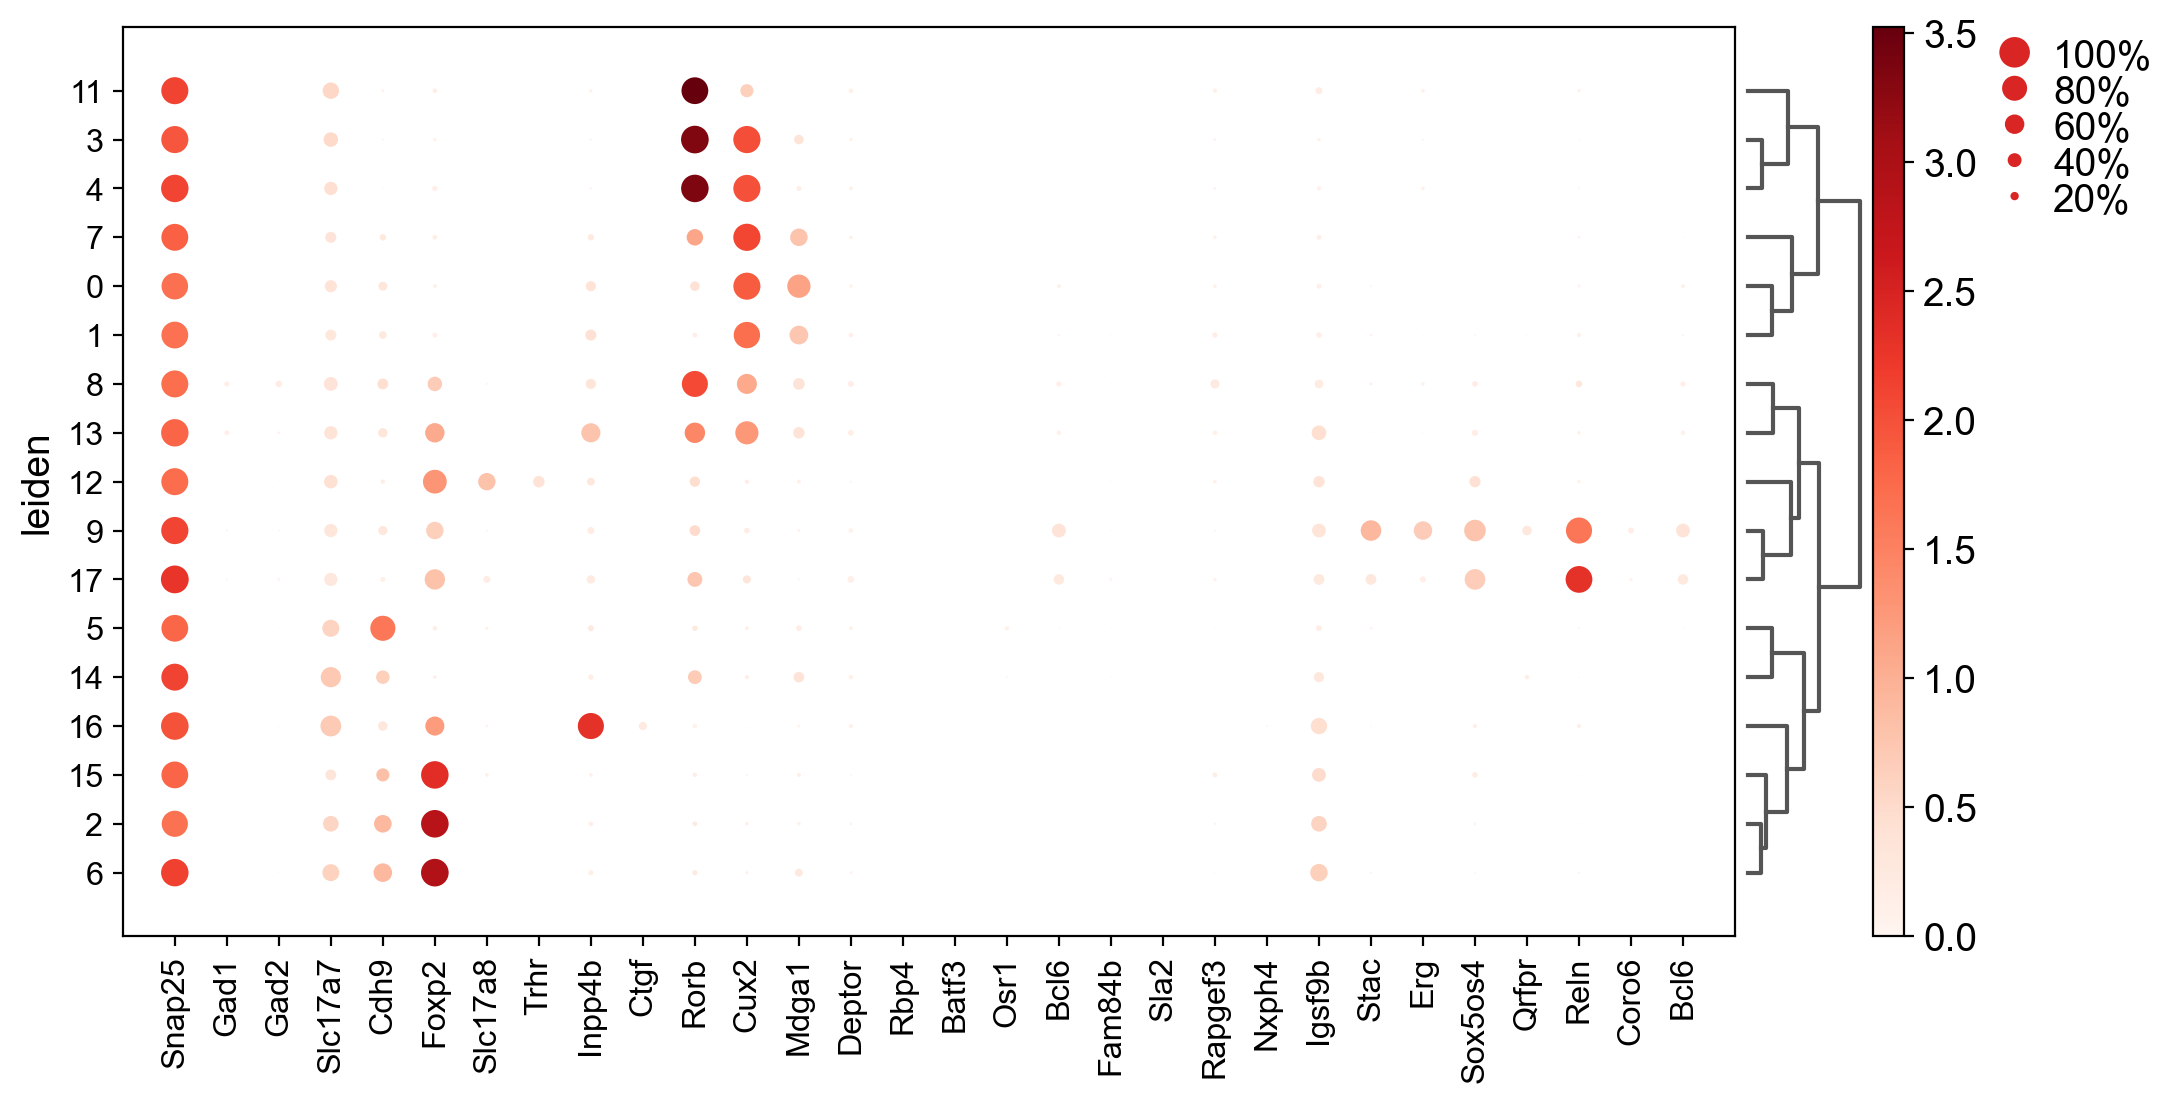

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[10.5, 0.8, 0.2, 0.5, 0.25])

In [184]:
sc.tl.dendrogram(P8_glut_test, groupby='leiden')
sc.pl.dotplot(P8_glut_test, bias_markers + L5PT_markers + ['Bcl6'], groupby='leiden', dendrogram=True)

In [185]:
P8_glut_test[P8_glut_test.obs.leiden=='9',:].shape[0] + P8_glut_test[P8_glut_test.obs.leiden=='17',:].shape[0] 

561

561 is a couple hundred smaller than the ~avg of L5PT cells in other ages but that's fine. Now need to remove the orange that's not 9 and 17 then re-run all clustering.

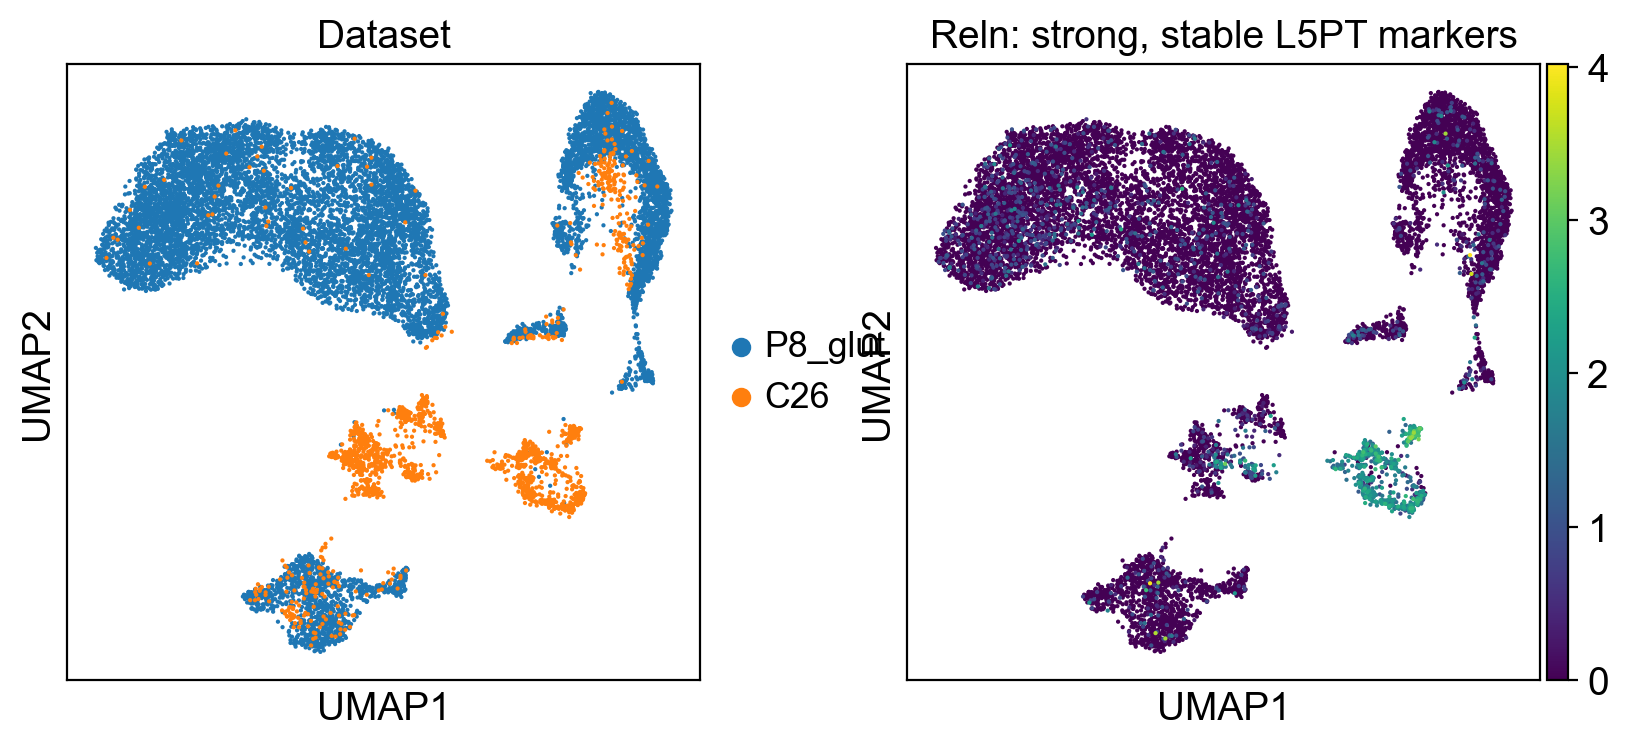

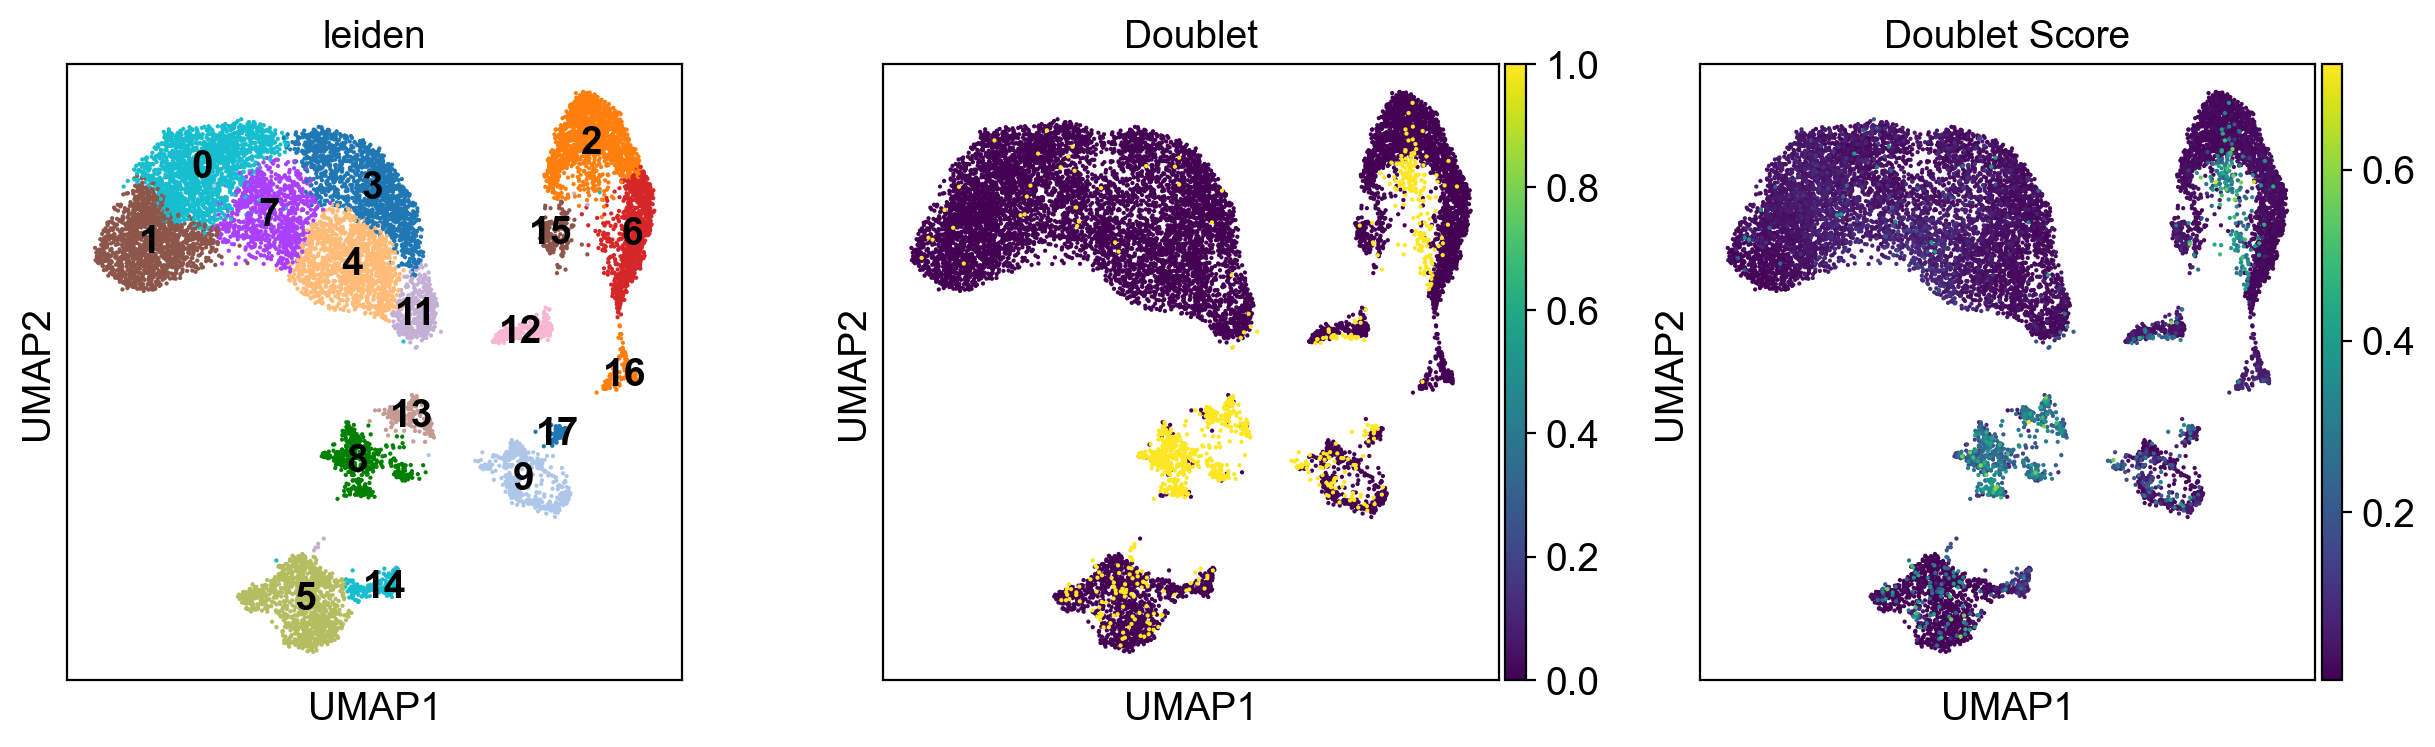

In [186]:
sc.pl.umap(P8_glut_test, color=['batch', 'Reln'], title=['Dataset', 'Reln: strong, stable L5PT markers'])
sc.pl.umap(P8_glut_test, color=['leiden', 'Doublet', 'Doublet Score'], legend_loc='on data')

Only a 100 out of 561 L5 PT cells labeled as doublets, but their doublet score is much lower than the other C26 doublets so they're (9 and 17) fine and can stay. The rest of C26 must go then re-cluster.

In [190]:
P8_glut_test.obs.batch

AAACCCAGTGAGACGT-1-P8_1a-P8-P8_glut    P8_glut
AAACCCATCTGCGATA-1-P8_1a-P8-P8_glut    P8_glut
AAACGCTCACTTCATT-1-P8_1a-P8-P8_glut    P8_glut
AAACGCTGTCGTTTCC-1-P8_1a-P8-P8_glut    P8_glut
AAAGAACCAGAGTGAC-1-P8_1a-P8-P8_glut    P8_glut
                                        ...   
TTTCGATGTATCTCGA-1-P8_2b-P8-C26            C26
TTTCGATTCATGCCGG-1-P8_2b-P8-C26            C26
TTTGACTTCTCCAAGA-1-P8_2b-P8-C26            C26
TTTGATCGTGCATACT-1-P8_2b-P8-C26            C26
TTTGTTGAGTCACGCC-1-P8_2b-P8-C26            C26
Name: batch, Length: 12824, dtype: category
Categories (2, object): [P8_glut, C26]

In [195]:
#the below is wrong
C26_decision = []
for i in range(P8_glut_test.shape[0]):
    if (P8_glut_test.obs.leiden[i] in ['9', '17']):
        C26_decision.append('keep')
    elif (P8_glut_test.obs.batch[i]=='C26'):
        C26_decision.append('remove')
    else: C26_decision.append('keep')

In [200]:
P8_glut_test.obs['C26_decision'] = P8_glut_test.obs['batch']
P8_glut_test.obs['C26_decision'] = C26_decision

In [202]:
P8_glut_test.obs['C26_decision']

AAACCCAGTGAGACGT-1-P8_1a-P8-P8_glut      keep
AAACCCATCTGCGATA-1-P8_1a-P8-P8_glut      keep
AAACGCTCACTTCATT-1-P8_1a-P8-P8_glut      keep
AAACGCTGTCGTTTCC-1-P8_1a-P8-P8_glut      keep
AAAGAACCAGAGTGAC-1-P8_1a-P8-P8_glut      keep
                                        ...  
TTTCGATGTATCTCGA-1-P8_2b-P8-C26        remove
TTTCGATTCATGCCGG-1-P8_2b-P8-C26        remove
TTTGACTTCTCCAAGA-1-P8_2b-P8-C26        remove
TTTGATCGTGCATACT-1-P8_2b-P8-C26        remove
TTTGTTGAGTCACGCC-1-P8_2b-P8-C26          keep
Name: C26_decision, Length: 12824, dtype: object

In [206]:
P8_glut_test = P8_glut_test[P8_glut_test.obs['C26_decision']!='remove',:]
P8_glut_test = P8_glut_test[P8_glut_test.obs['leiden']!='8',:]
P8_glut_test = P8_glut_test[P8_glut_test.obs['leiden']!='13',:]

In [207]:
P8_glut_test

View of AnnData object with n_obs × n_vars = 11691 × 30869 
    obs: 'Age', 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'cluster', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'subclass', 'C26_decision'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable-P8_glut', 'means-P8_glut', 'dispersions-P8_glut', 'dispersions_norm-P8_glut', 'mean-P8_glut', 'std-P8_glut', 'highly_variable-C26', 'means-C26', 'dispersions-C26', 'dispersions_norm-C26', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'sample_colors', 'dendrogram_leiden', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

Check: good.

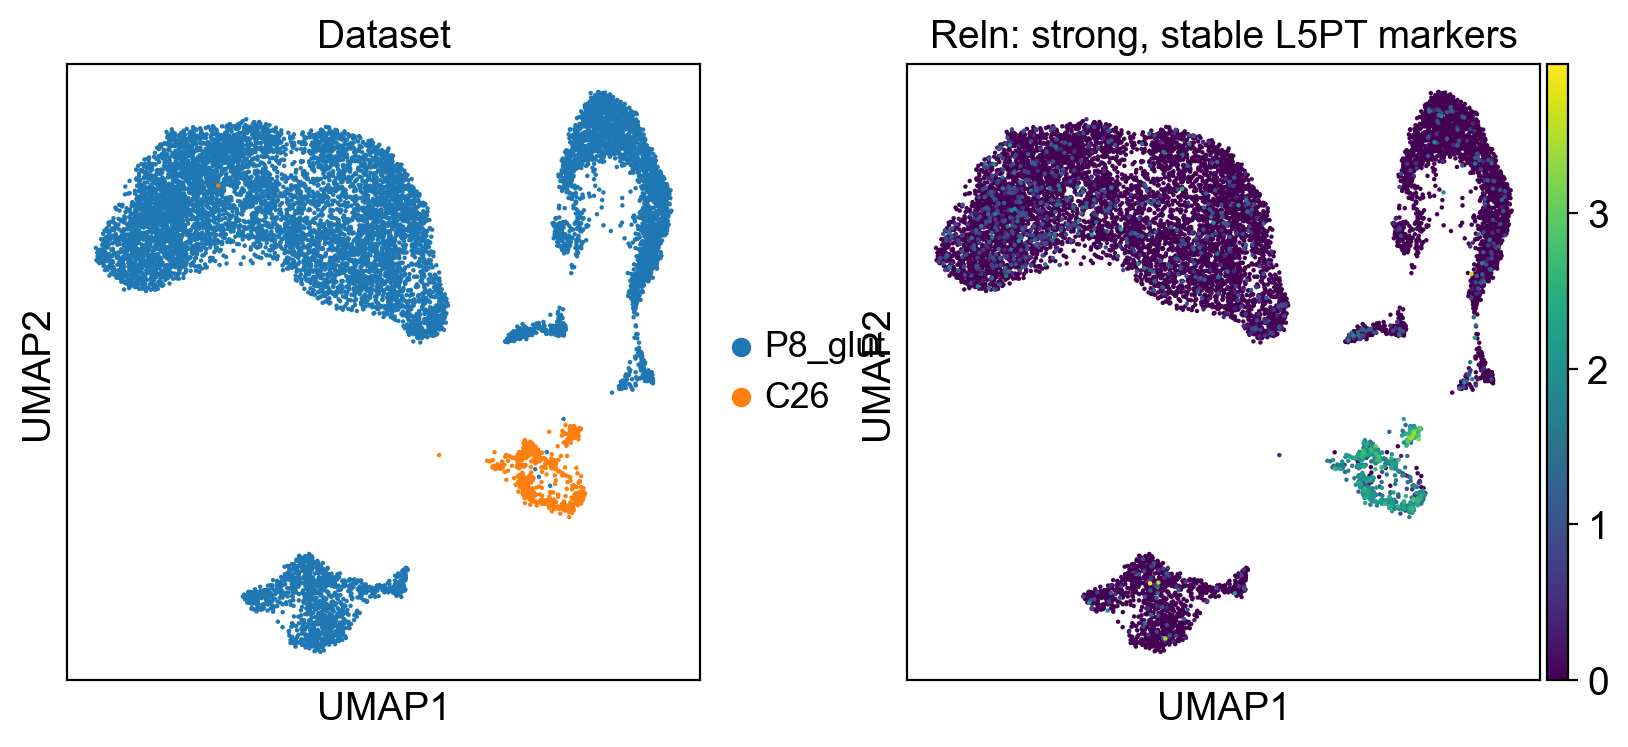

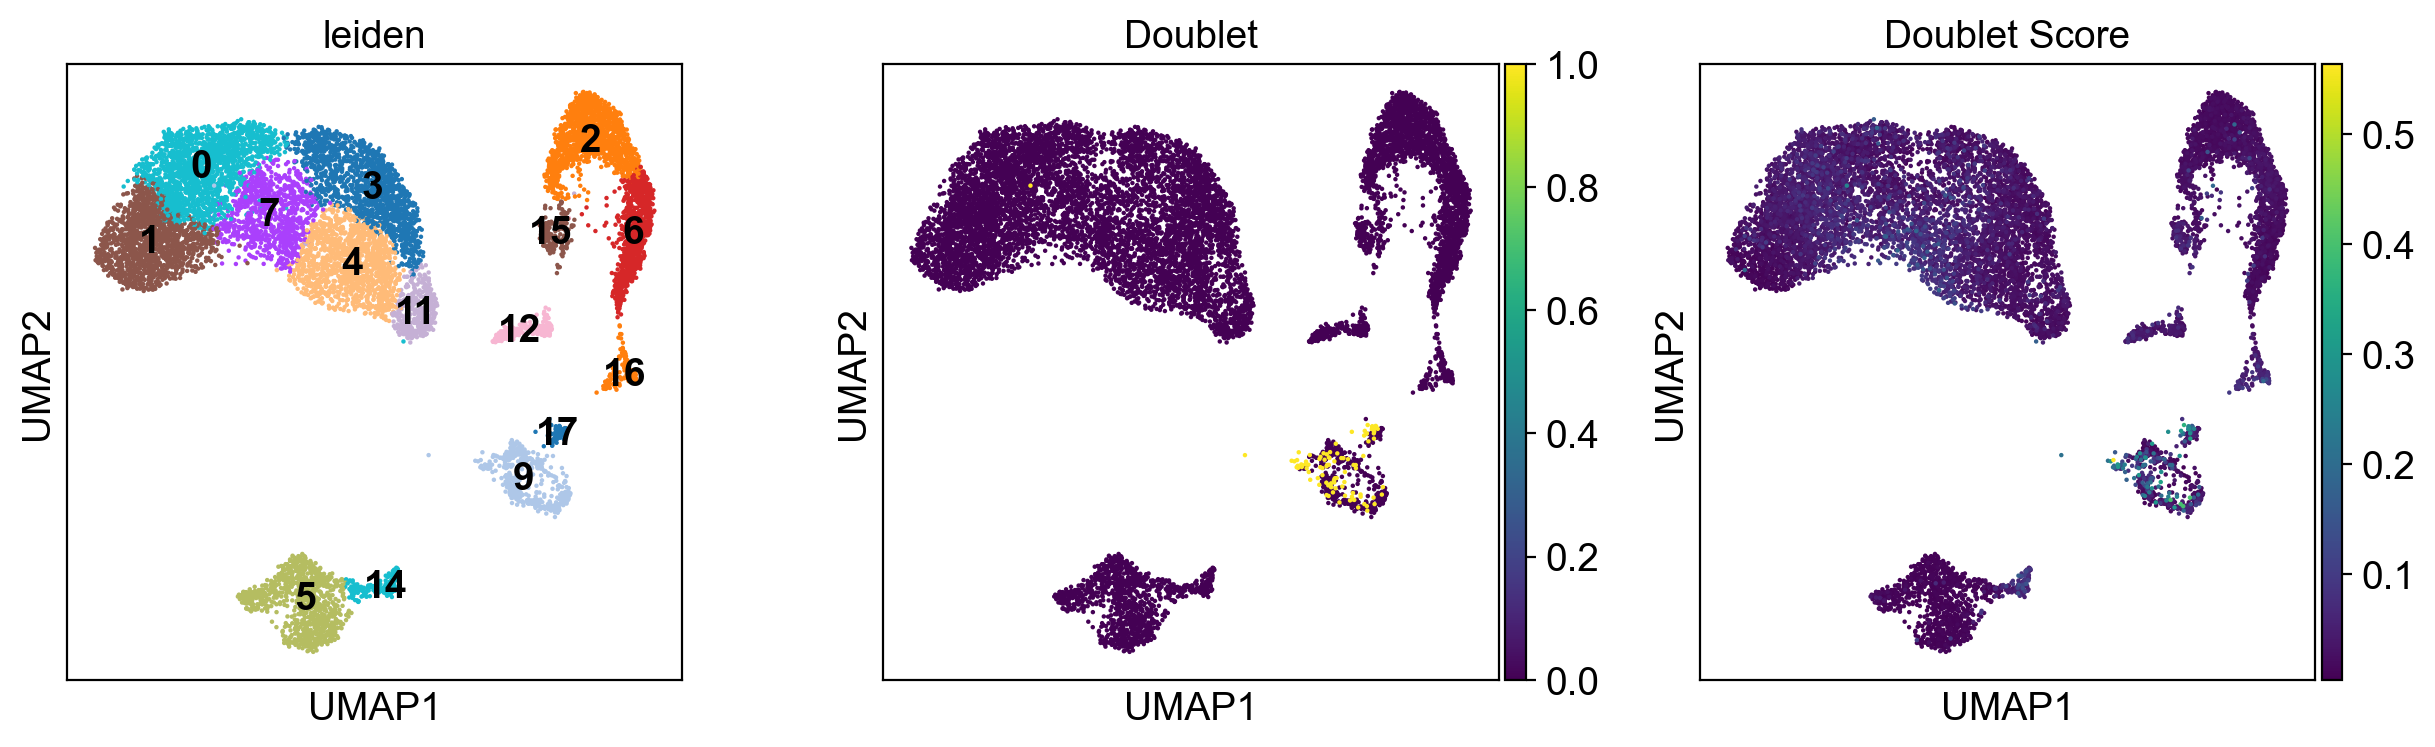

In [208]:
sc.pl.umap(P8_glut_test, color=['batch', 'Reln'], title=['Dataset', 'Reln: strong, stable L5PT markers'])
sc.pl.umap(P8_glut_test, color=['leiden', 'Doublet', 'Doublet Score'], legend_loc='on data')

Re-cluster

## New P8 atlas

In [9]:
P8_glut_test = sc.read_h5ad('P8_glut08102020_use.h5ad')

In [6]:
del P8_glut_test.obsp
del P8_glut_test.varm
del P8_glut_test.obsm
del P8_glut_test.uns
P8_glut_test.X = P8_glut_test.raw.X
sc.pp.highly_variable_genes(P8_glut_test, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs
sc.pp.scale(P8_glut_test, max_value=10) #scale
sc.tl.pca(P8_glut_test, svd_solver='arpack') #run PCA

'''
P8_glut_test_CBs = list(P8_glut_test.obs.index)
P8_glut_test_batch = []
for i in range(len(P8_glut_test_CBs)):
    P8_glut_test_batch.append(P8_glut_test_CBs[i][19:25])
    
P8_glut_test.obs['sample'] = P8_glut_test.obs['batch']
P8_glut_test.obs['sample'] = P8_glut_test_batch
'''
#sc.pp.neighbors(P8_glut_test, n_neighbors=25, n_pcs=40) #choose 25 standard for now
bbknn(P8_glut_test, batch_key='sample',neighbors_within_batch=5 ) #6*4~=25
sc.tl.leiden(P8_glut_test)
sc.tl.umap(P8_glut_test)

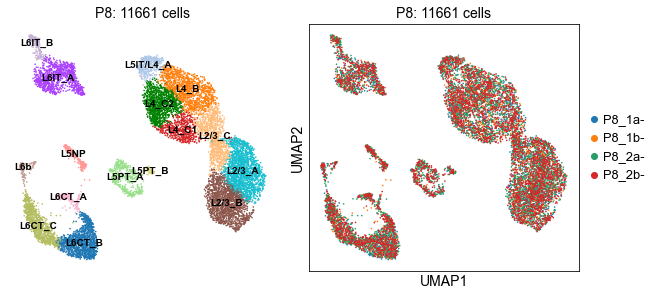

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)
sc.pl.umap(P8_glut_test, color='cluster', legend_fontsize='10', ax=axs[0], 
           show=False, title='P8: ' + str(P8_glut_test.shape[0]) + ' cells', frameon=False, 
          palette=('#17becf', '#8c564b', '#1f77b4', '#ff7f0e', 
                  'green', '#aa40fc', '#b5bd61', '#ffbb78', 
                  '#d62728', '#98df8a', '#aec7e8', '#ff9896', 
                  '#f7b6d2', '#c5b0d5', '#c49c94', '#dbdb8d'), legend_loc='on data')
sc.pl.umap(P8_glut_test, color='sample', ax=axs[1], show=False, title='P8: ' + str(P8_glut_test.shape[0]) + ' cells')

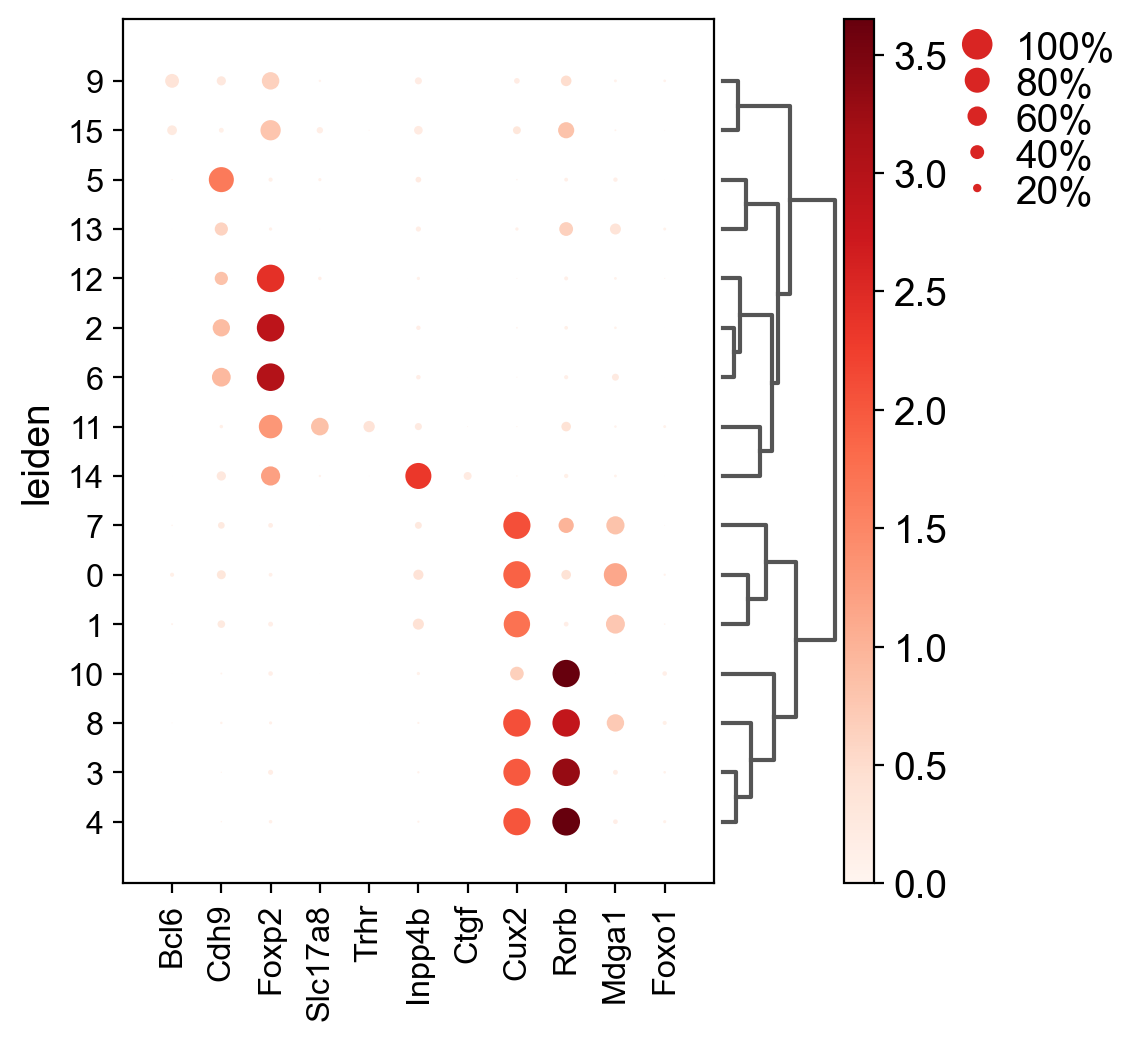

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.8499999999999996, 0.8, 0.2, 0.5, 0.25])

In [23]:
sc.tl.dendrogram(P8_glut_test, groupby='leiden')
bias_markers = ['Bcl6', 'Cdh9', 'Foxp2',  'Slc17a8', 'Trhr', 'Inpp4b', 'Ctgf', 'Cux2', 'Rorb', 'Mdga1', 'Foxo1']
sc.pl.dotplot(P8_glut_test, bias_markers, 
              groupby='leiden', dendrogram=True)

P8_glut_test = P8_glut_test[P8_glut_test.obs['leiden']!='16',:]

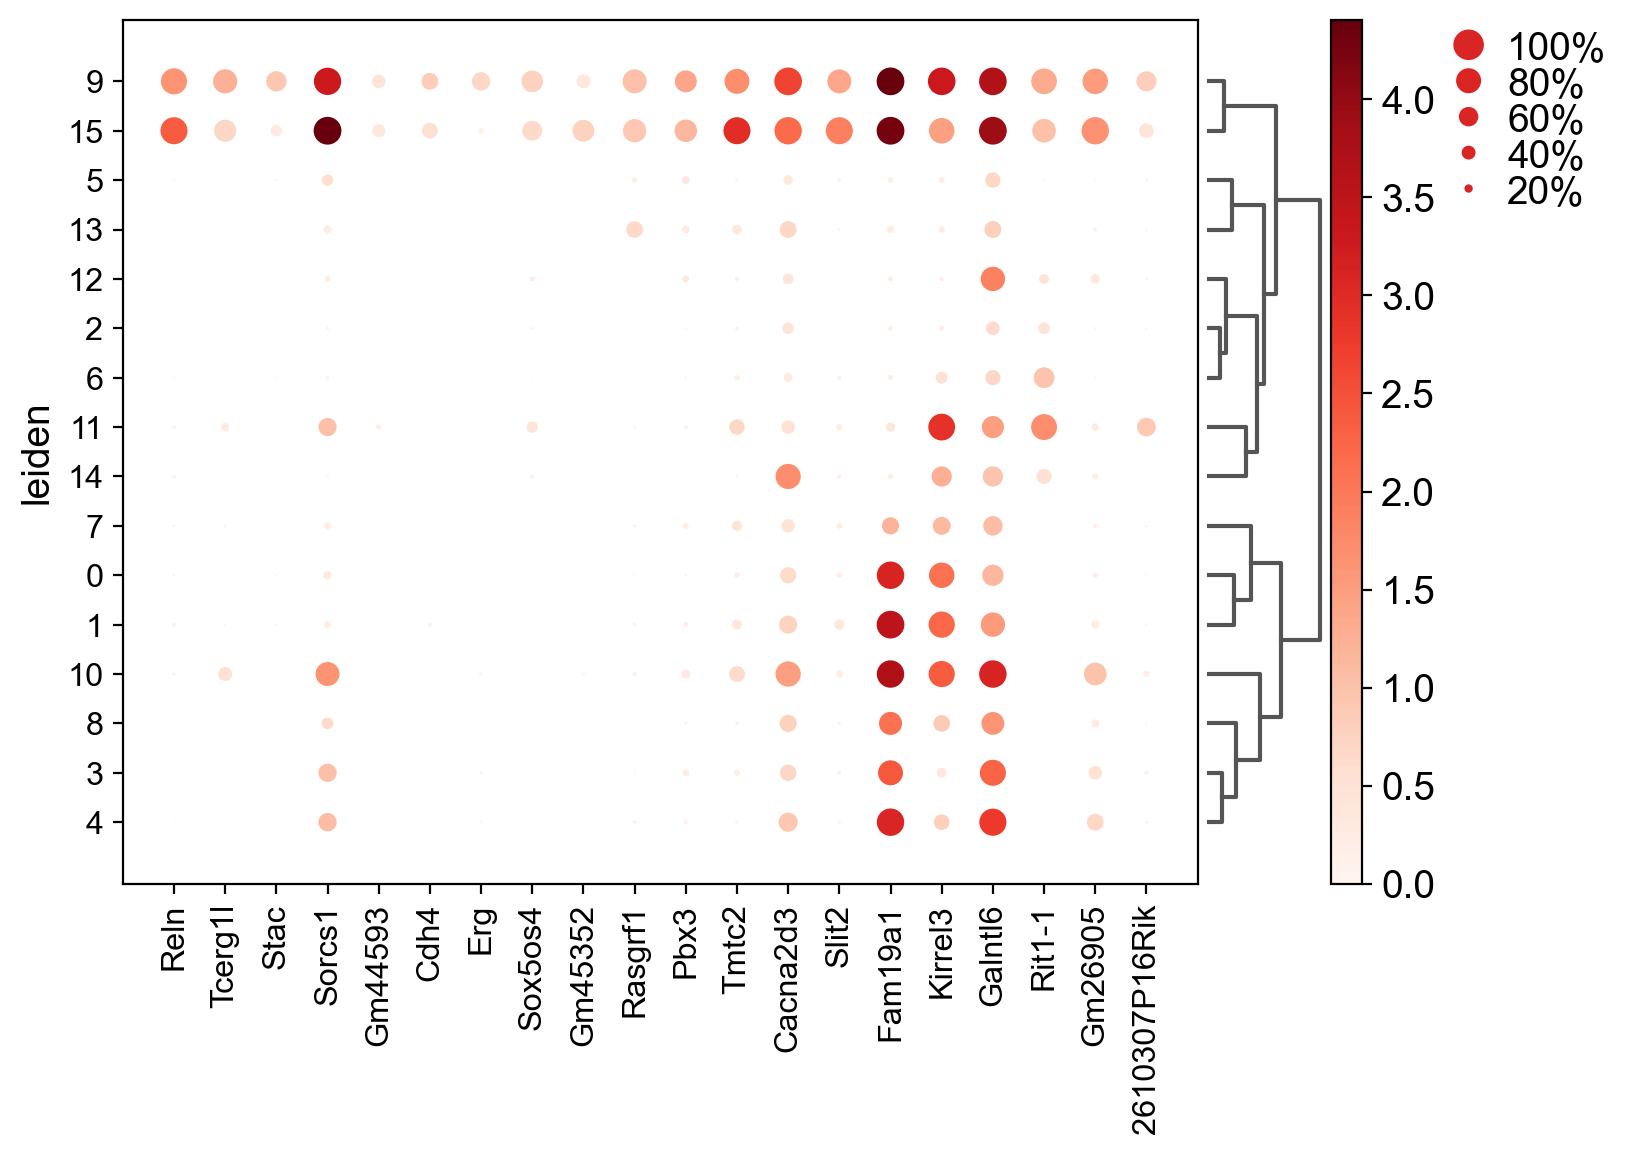

['Reln', 'Tcerg1l', 'Stac', 'Sorcs1', 'Gm44593', 'Cdh4']


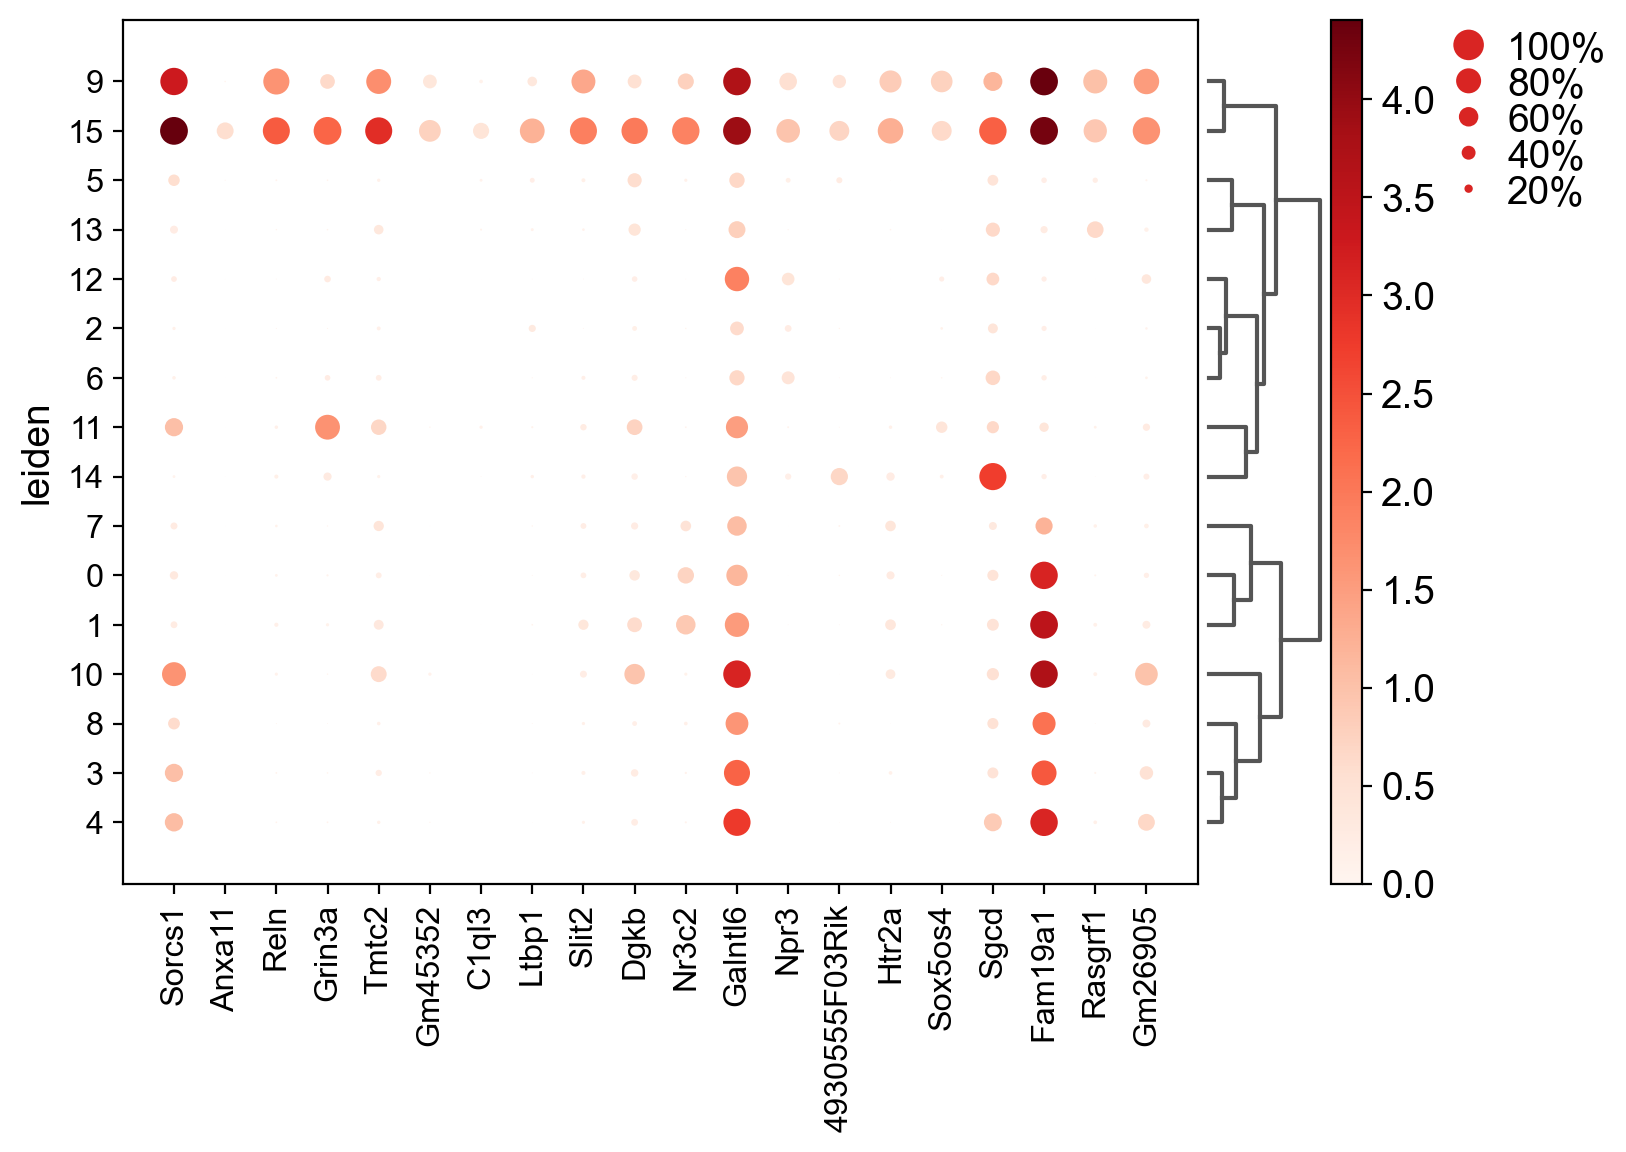

['Sorcs1', 'Anxa11', 'Reln', 'Grin3a', 'Tmtc2', 'Gm45352']


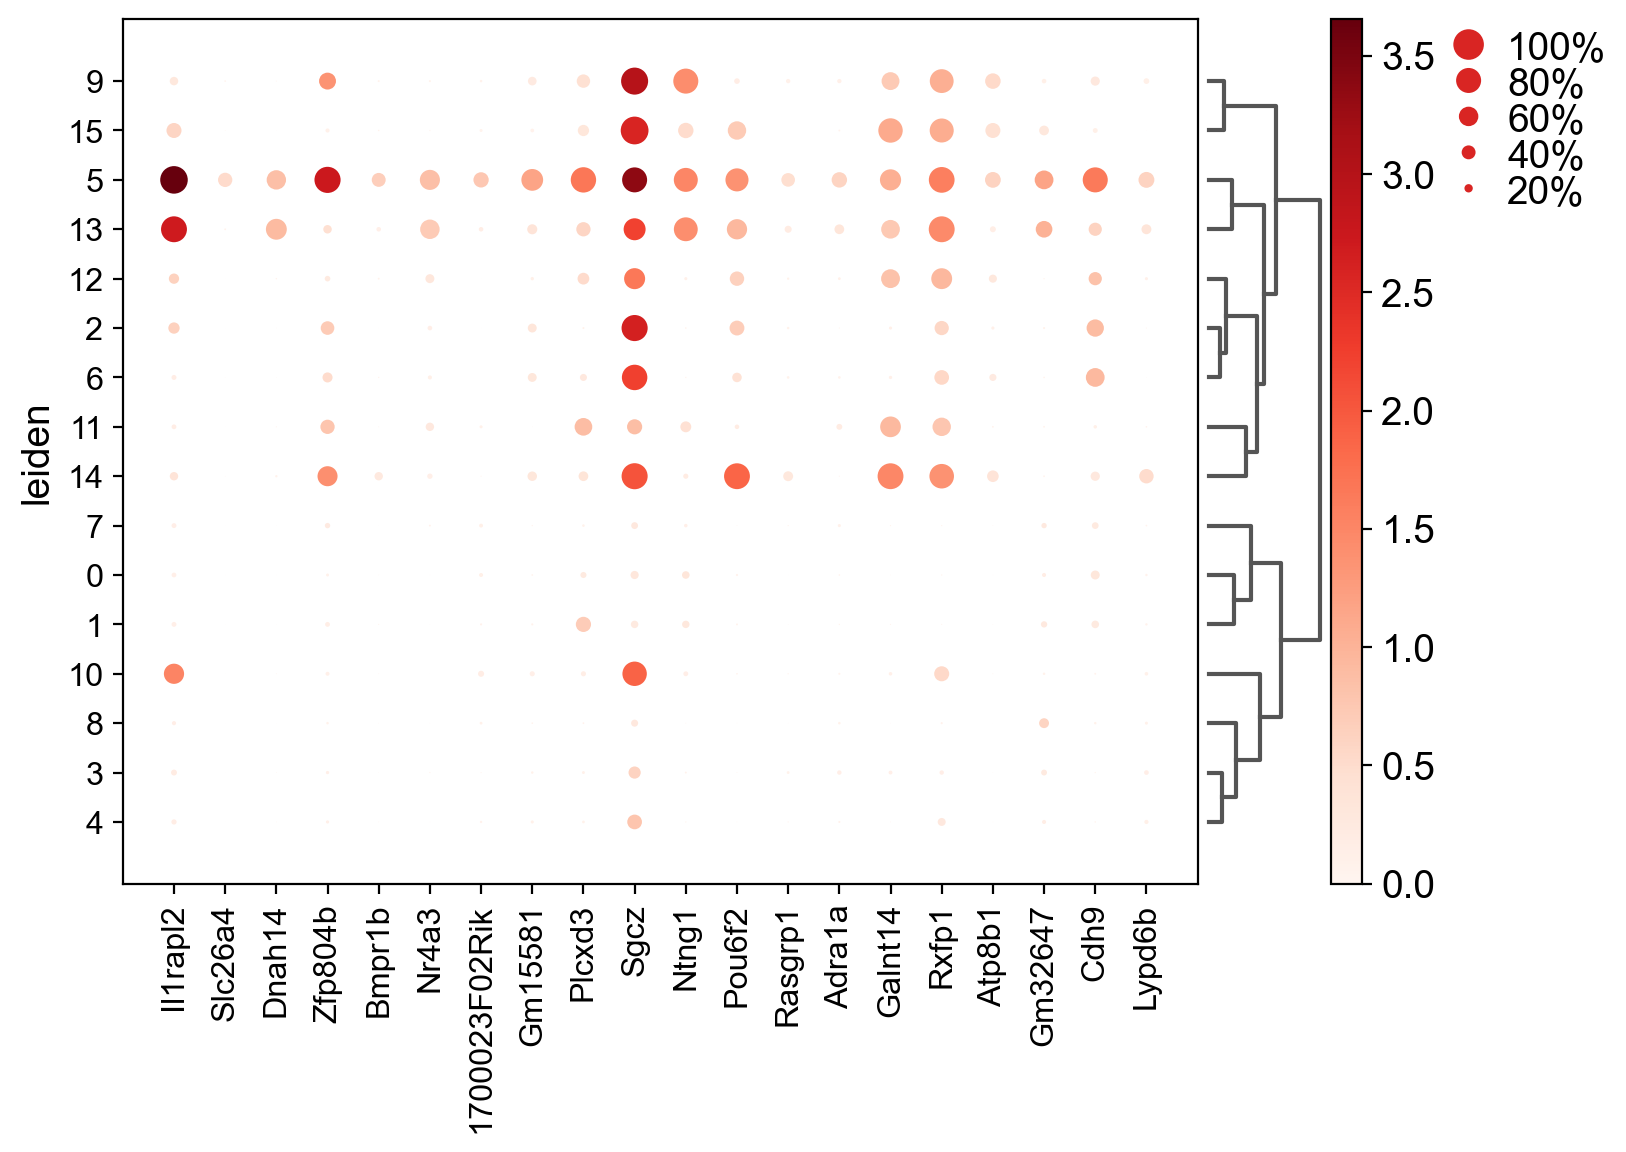

['Il1rapl2', 'Slc26a4', 'Dnah14', 'Zfp804b', 'Bmpr1b', 'Nr4a3']


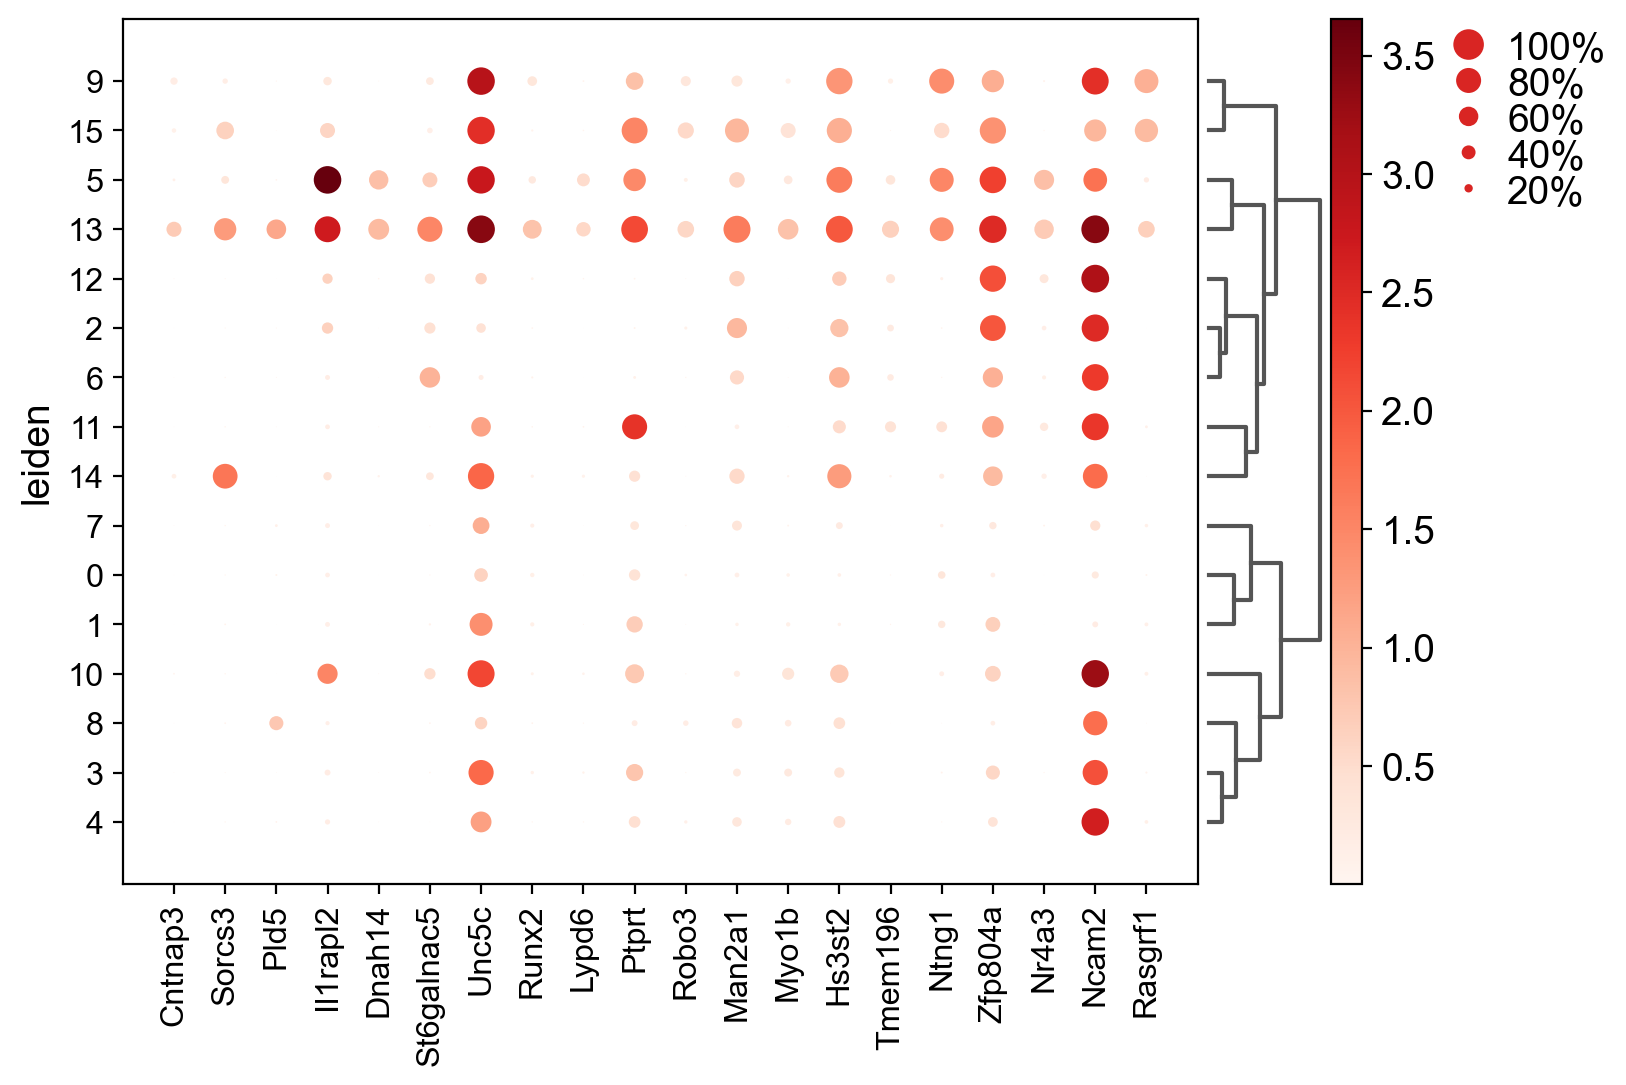

['Cntnap3', 'Sorcs3', 'Pld5', 'Il1rapl2', 'Dnah14', 'St6galnac5']


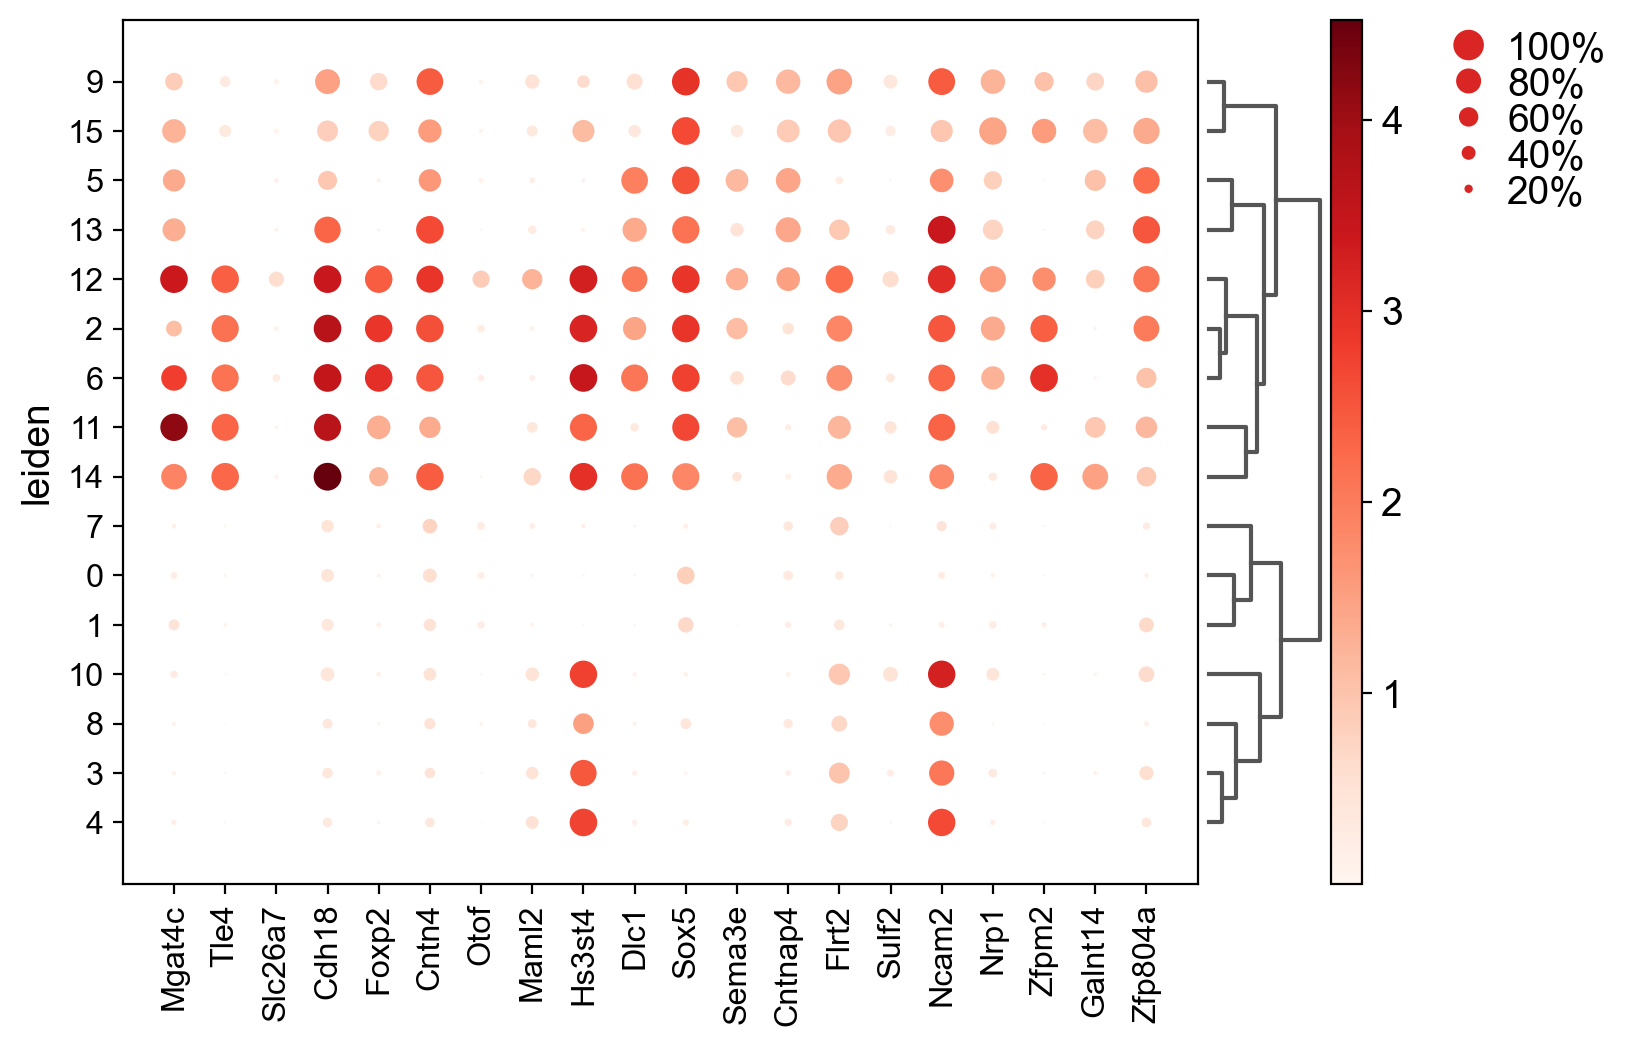

['Mgat4c', 'Tle4', 'Slc26a7', 'Cdh18', 'Foxp2', 'Cntn4']


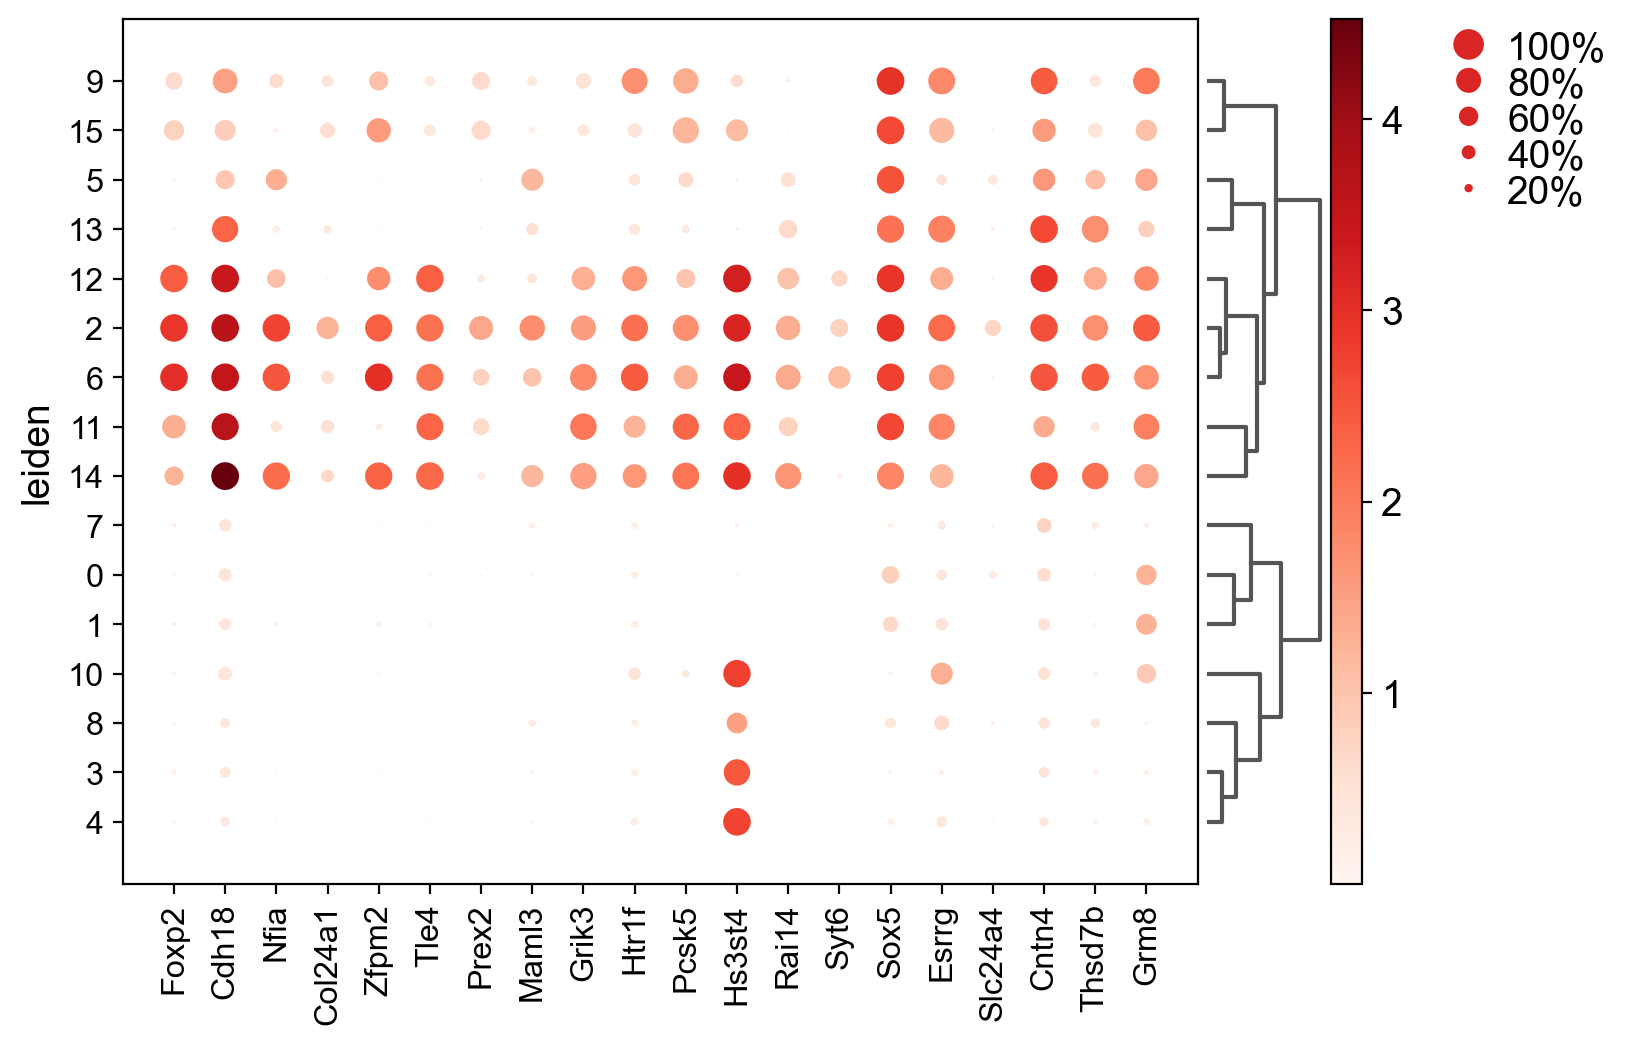

['Foxp2', 'Cdh18', 'Nfia', 'Col24a1', 'Zfpm2', 'Tle4']


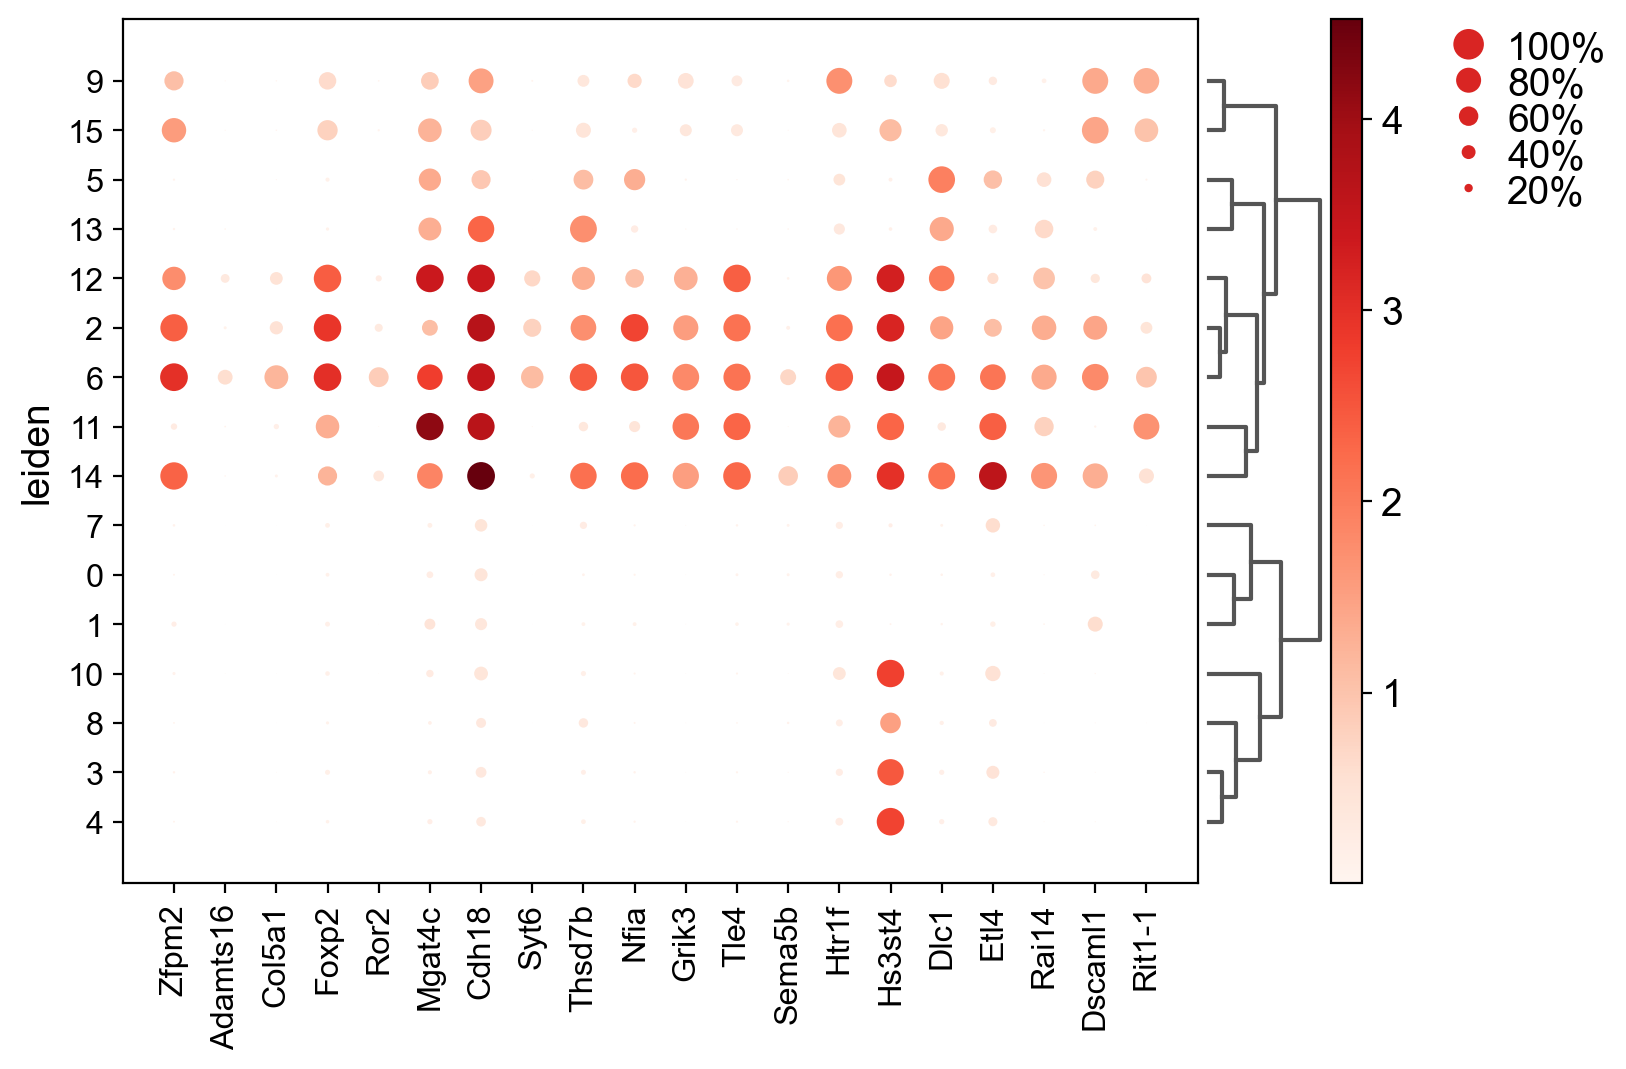

['Zfpm2', 'Adamts16', 'Col5a1', 'Foxp2', 'Ror2', 'Mgat4c']


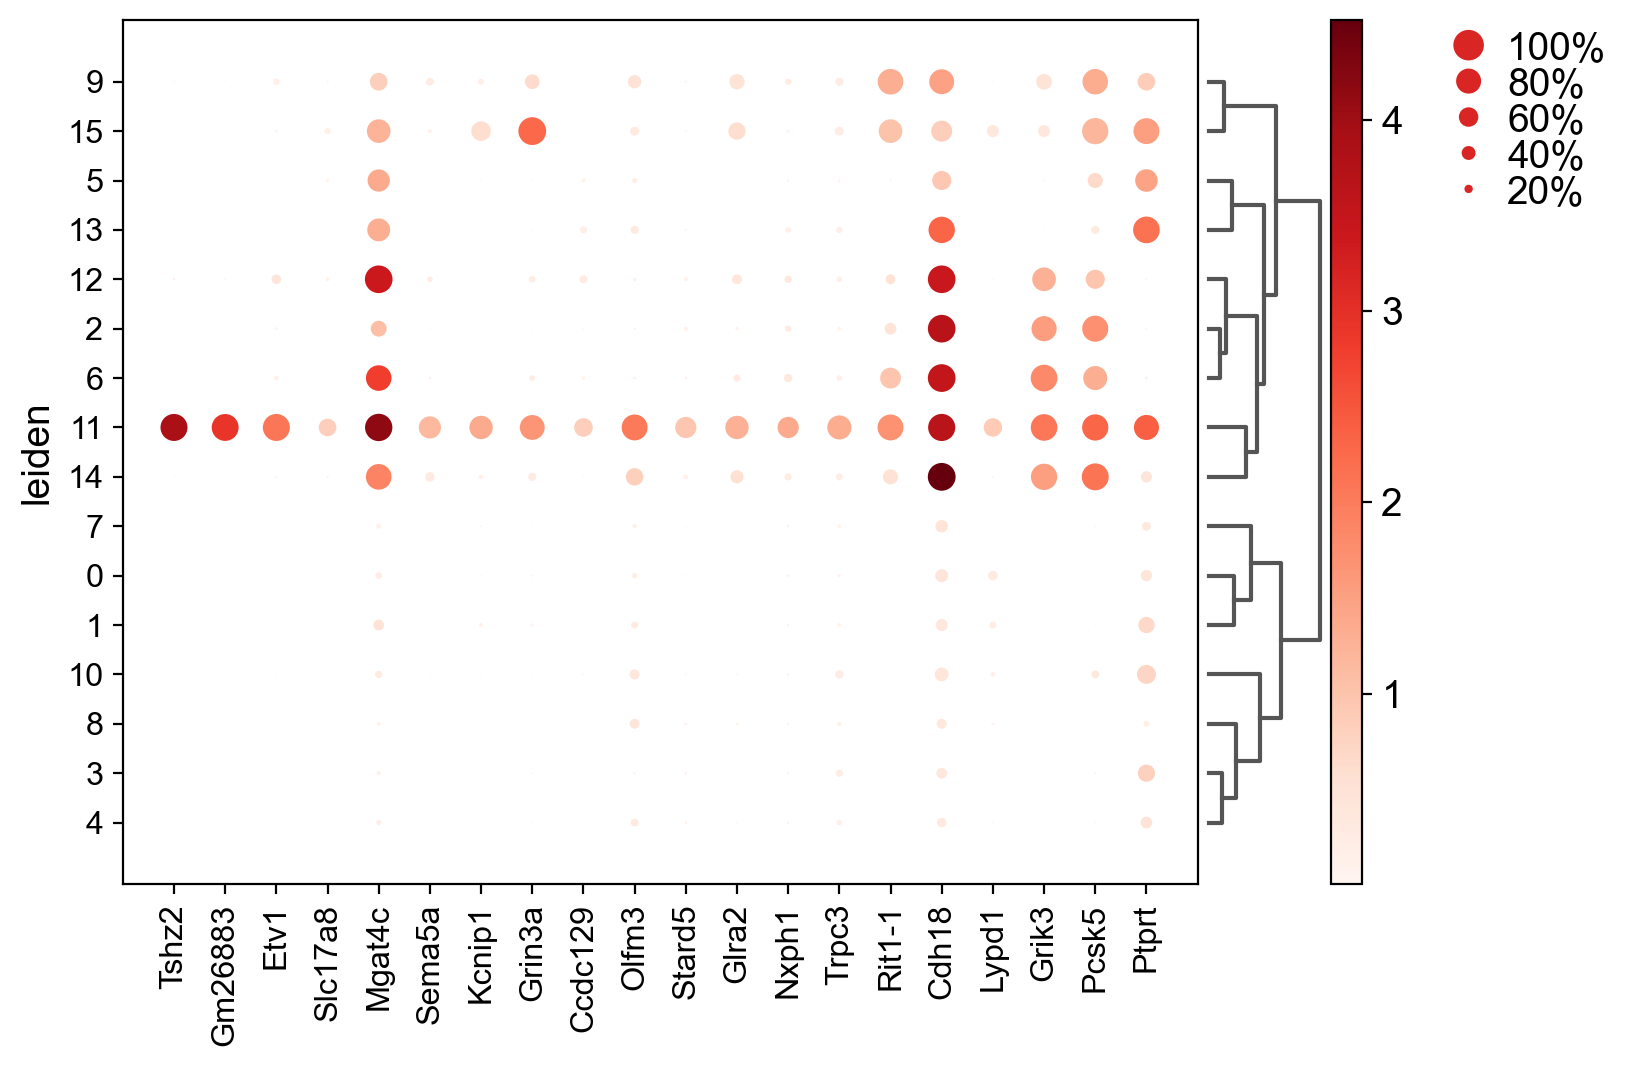

['Tshz2', 'Gm26883', 'Etv1', 'Slc17a8', 'Mgat4c', 'Sema5a']


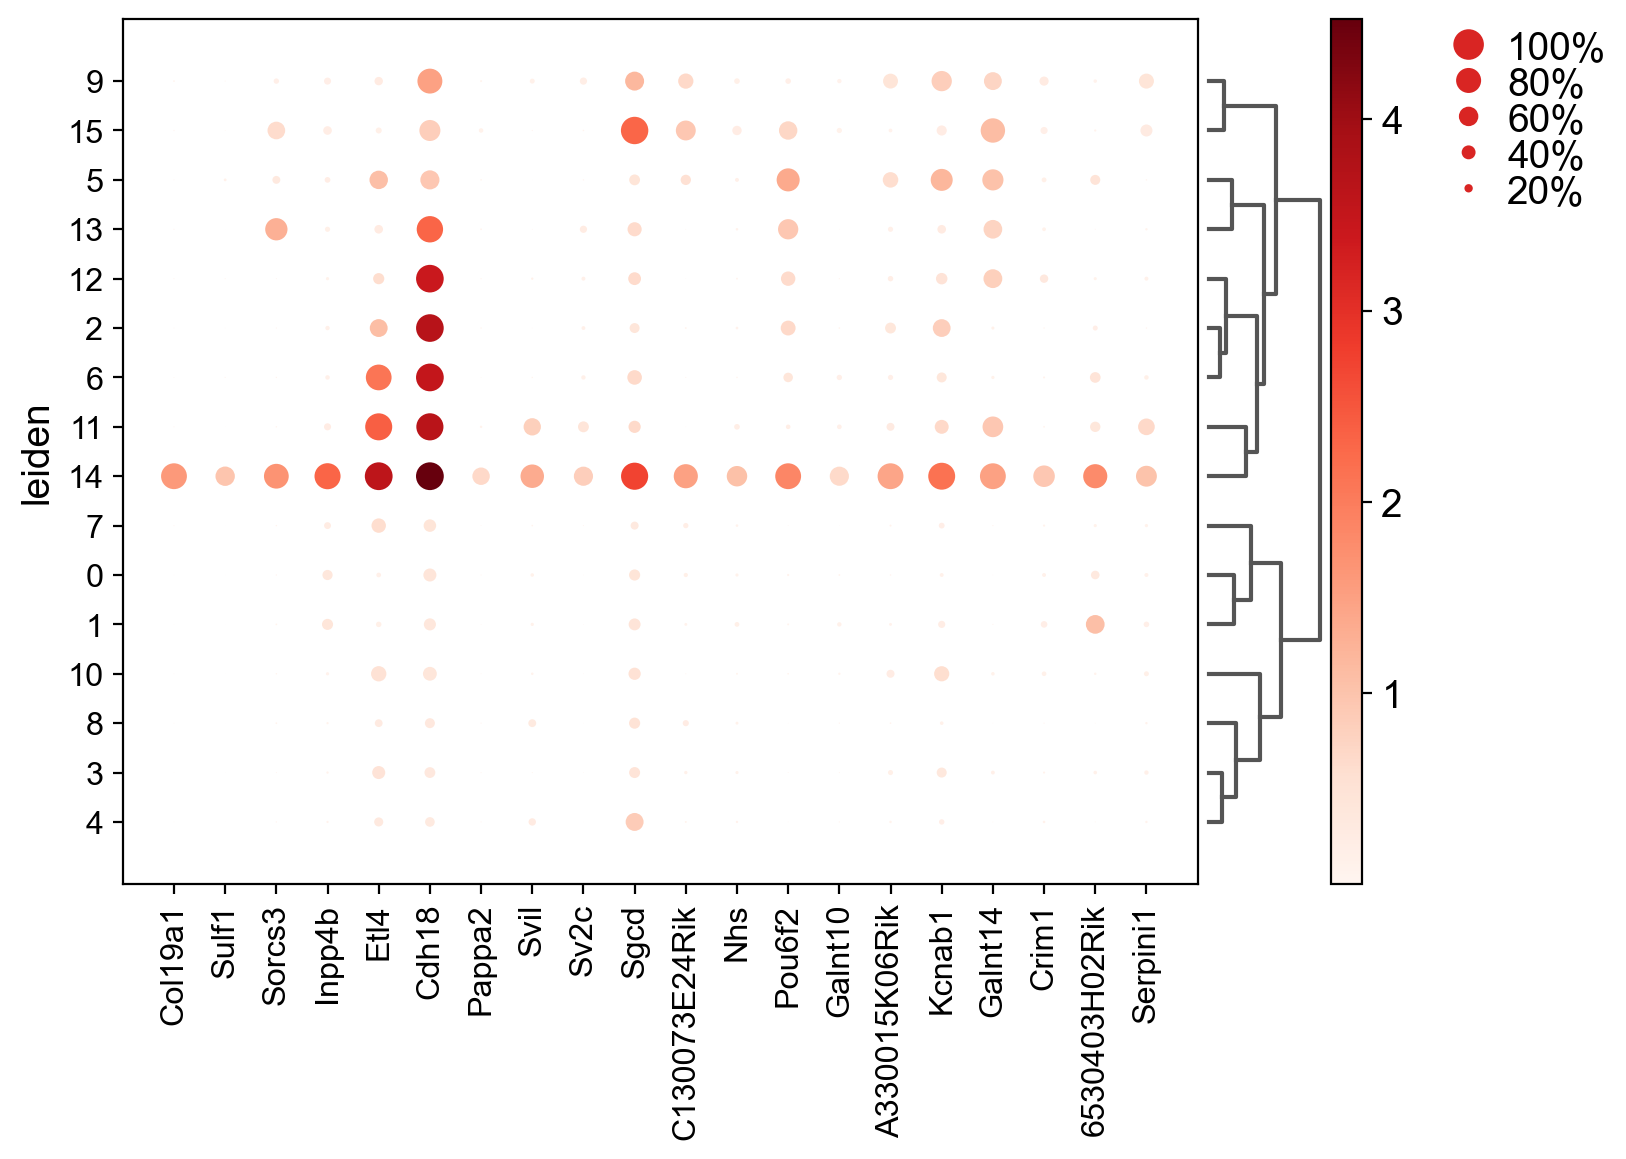

['Col19a1', 'Sulf1', 'Sorcs3', 'Inpp4b', 'Etl4', 'Cdh18']


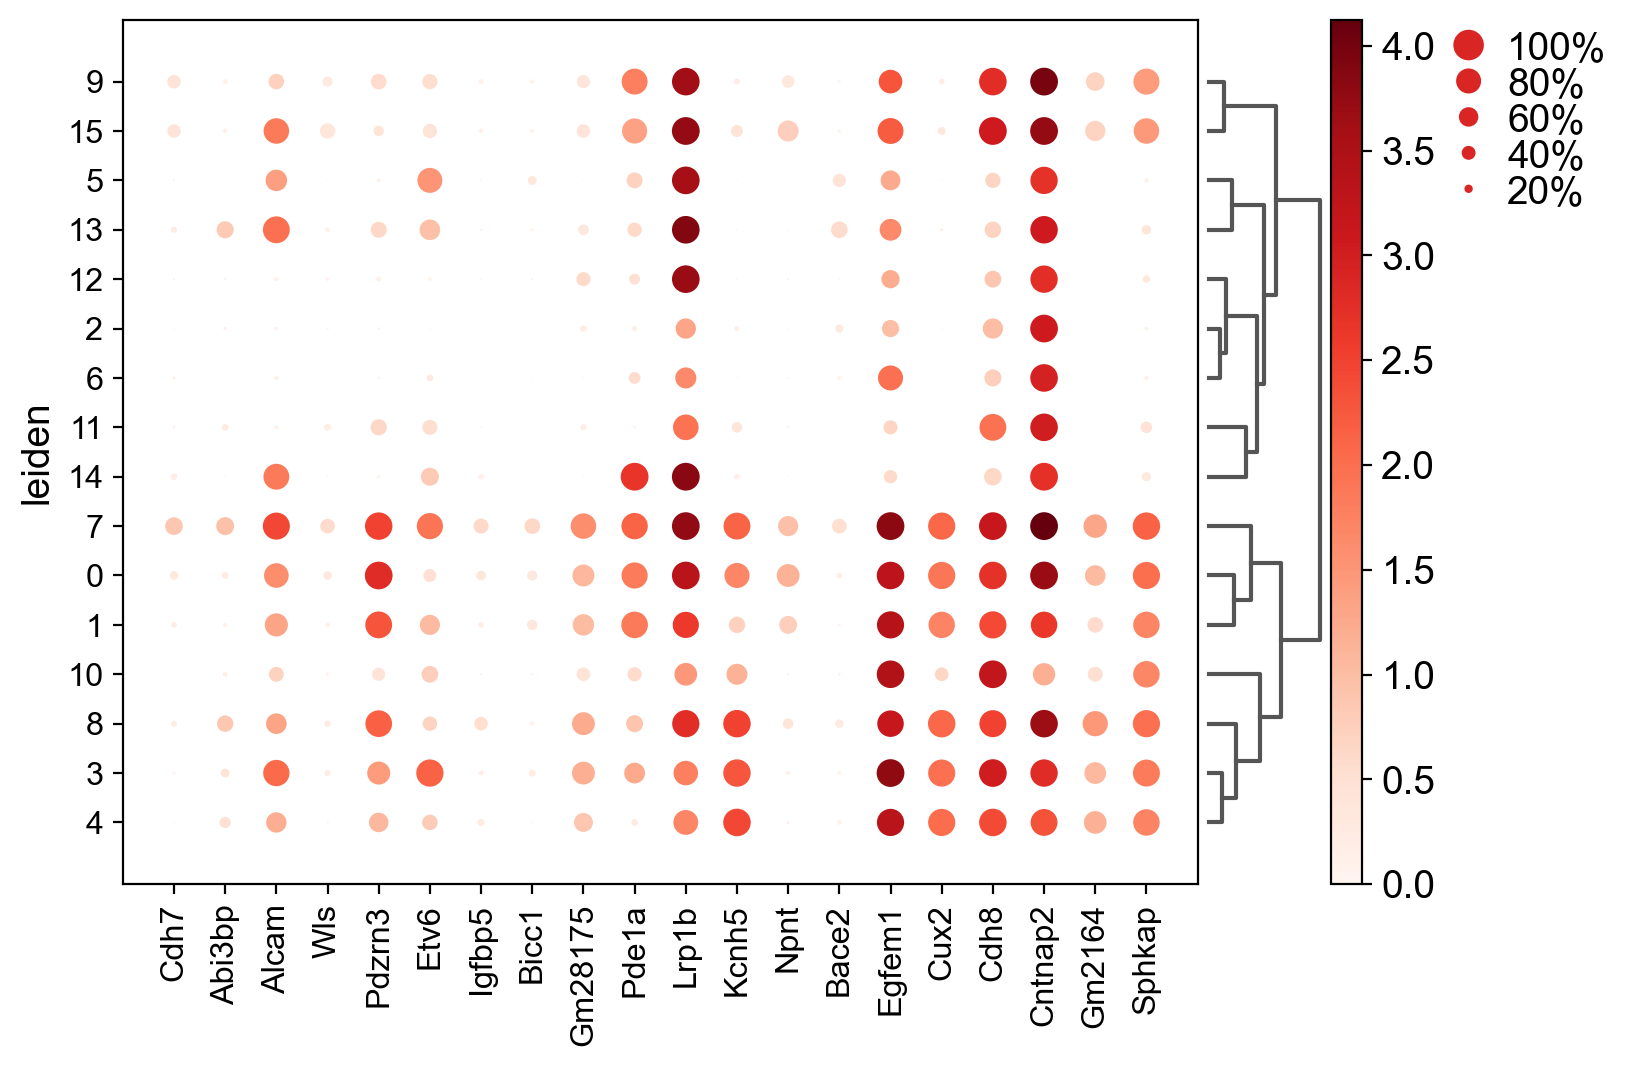

['Cdh7', 'Abi3bp', 'Alcam', 'Wls', 'Pdzrn3', 'Etv6']


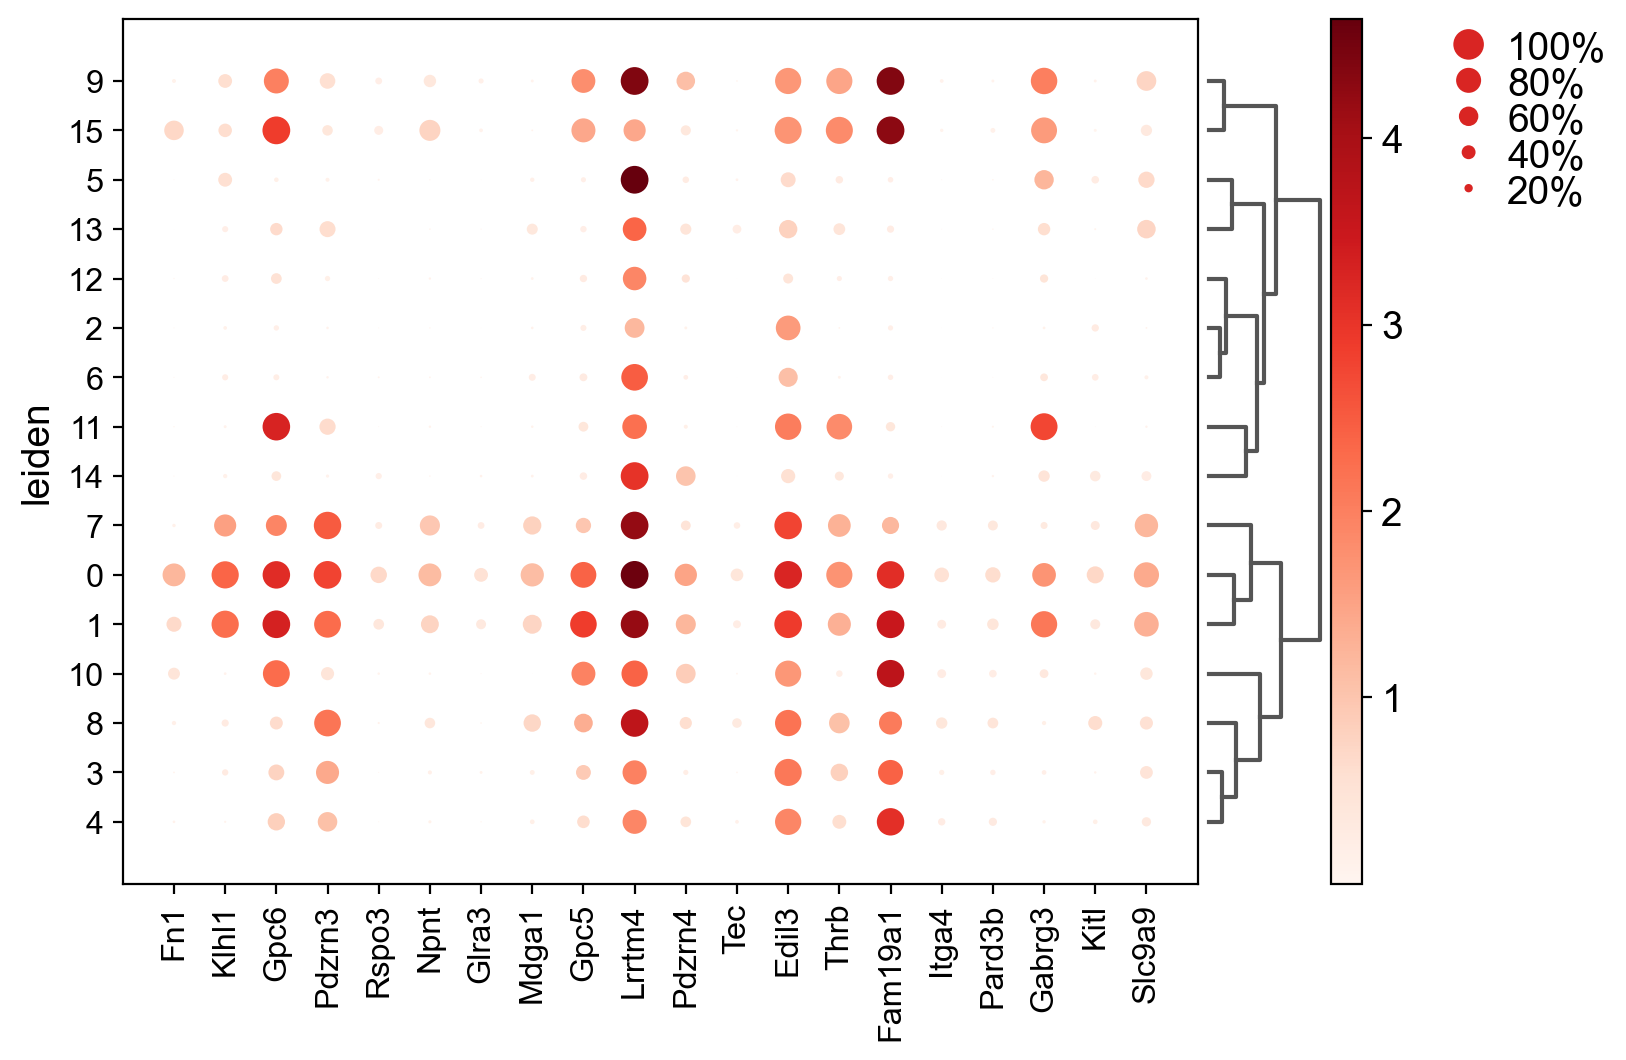

['Fn1', 'Klhl1', 'Gpc6', 'Pdzrn3', 'Rspo3', 'Npnt']


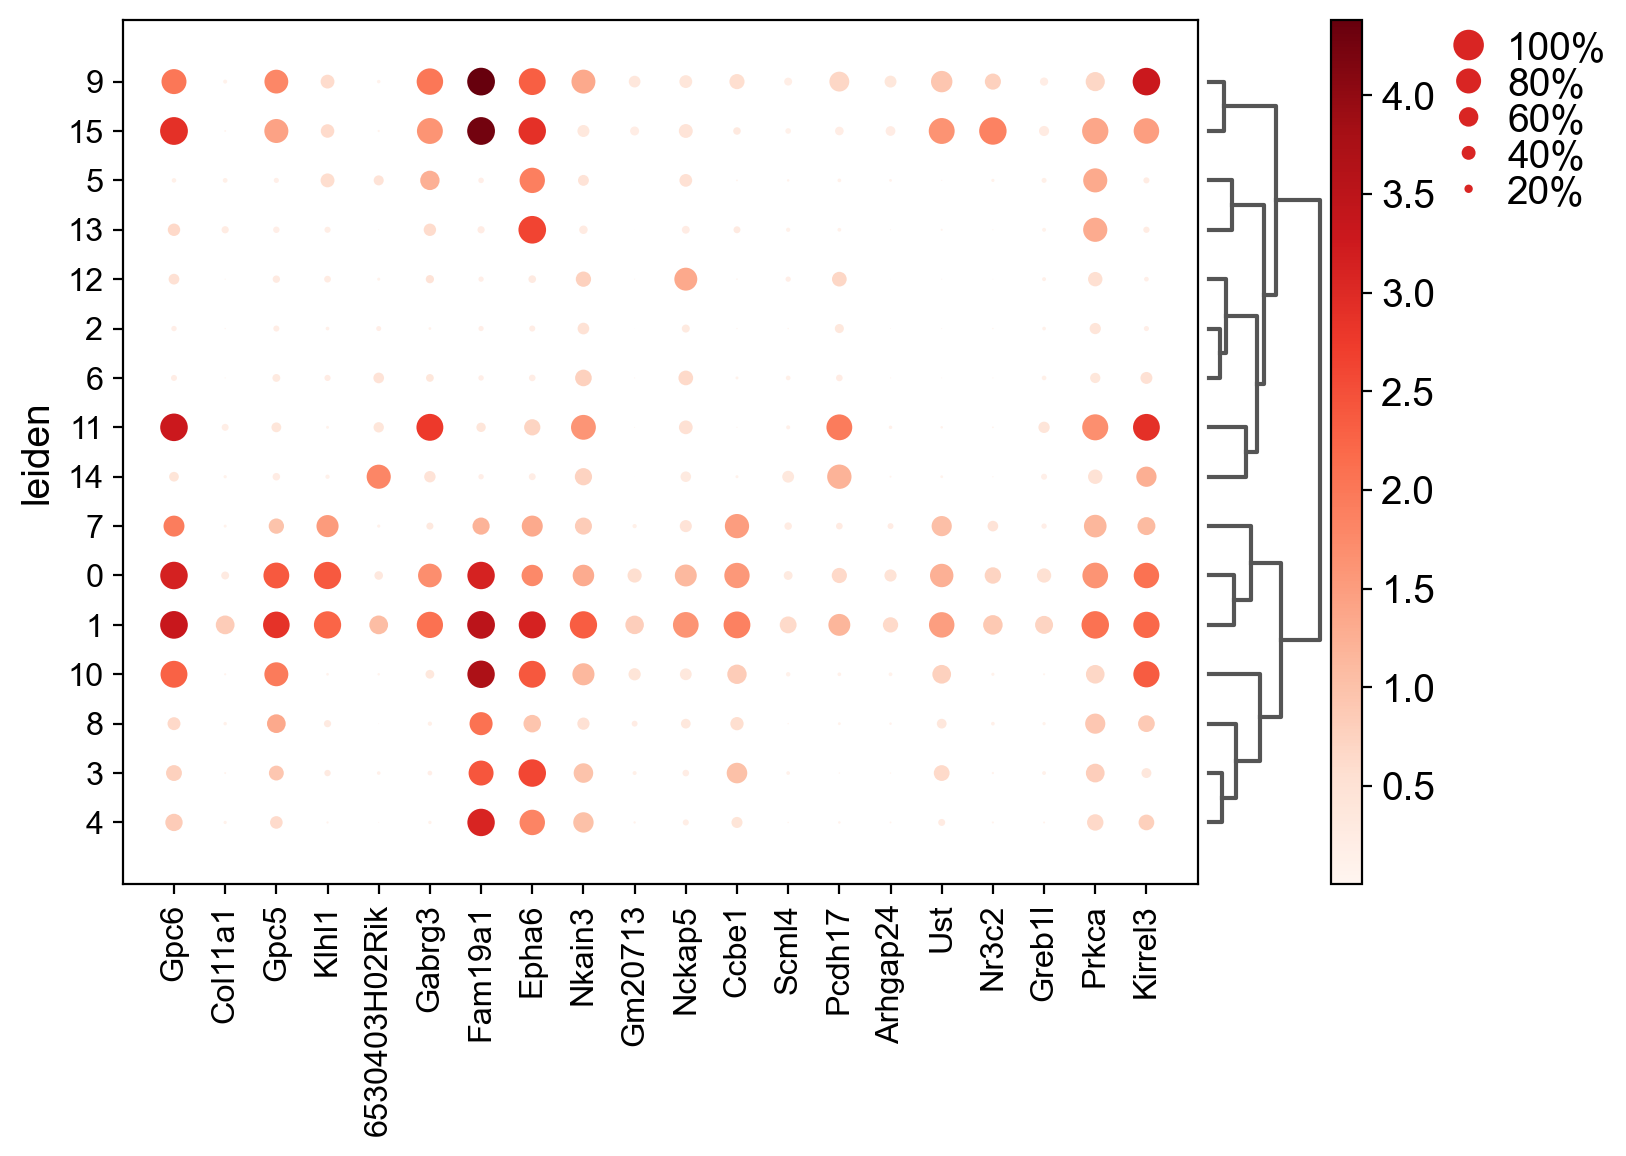

['Gpc6', 'Col11a1', 'Gpc5', 'Klhl1', '6530403H02Rik', 'Gabrg3']


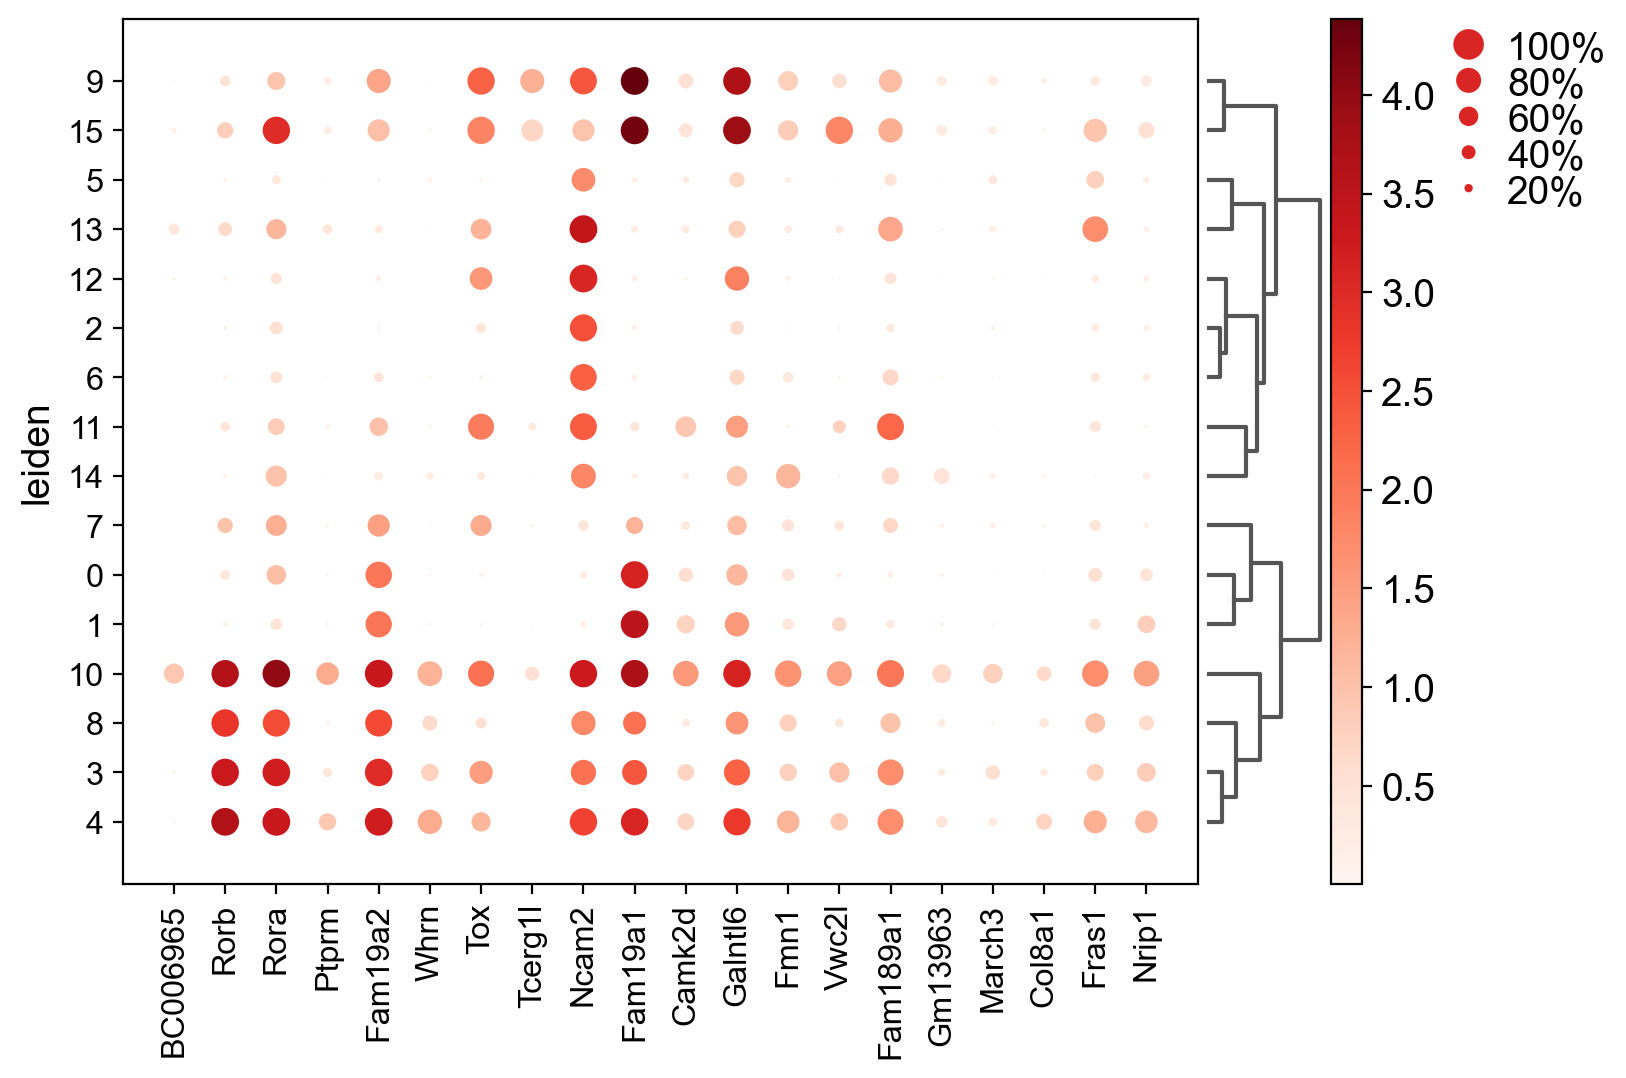

['BC006965', 'Rorb', 'Rora', 'Ptprm', 'Fam19a2', 'Whrn']


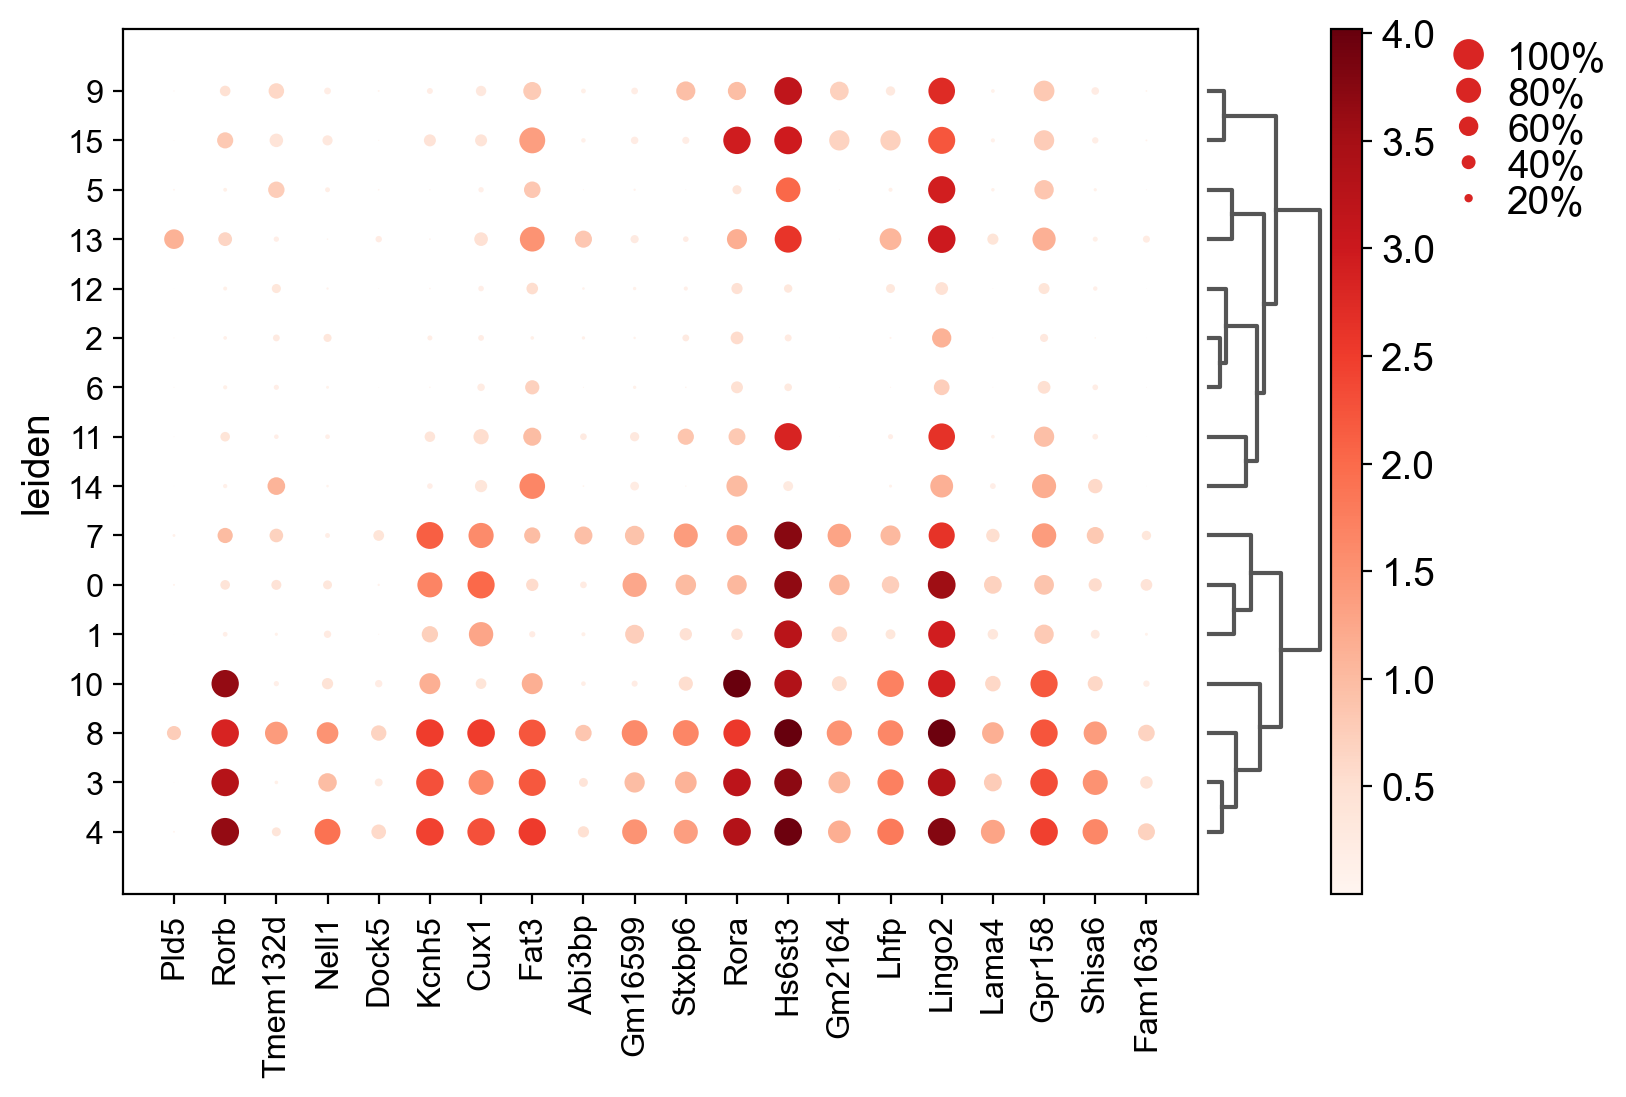

['Pld5', 'Rorb', 'Tmem132d', 'Nell1', 'Dock5', 'Kcnh5']


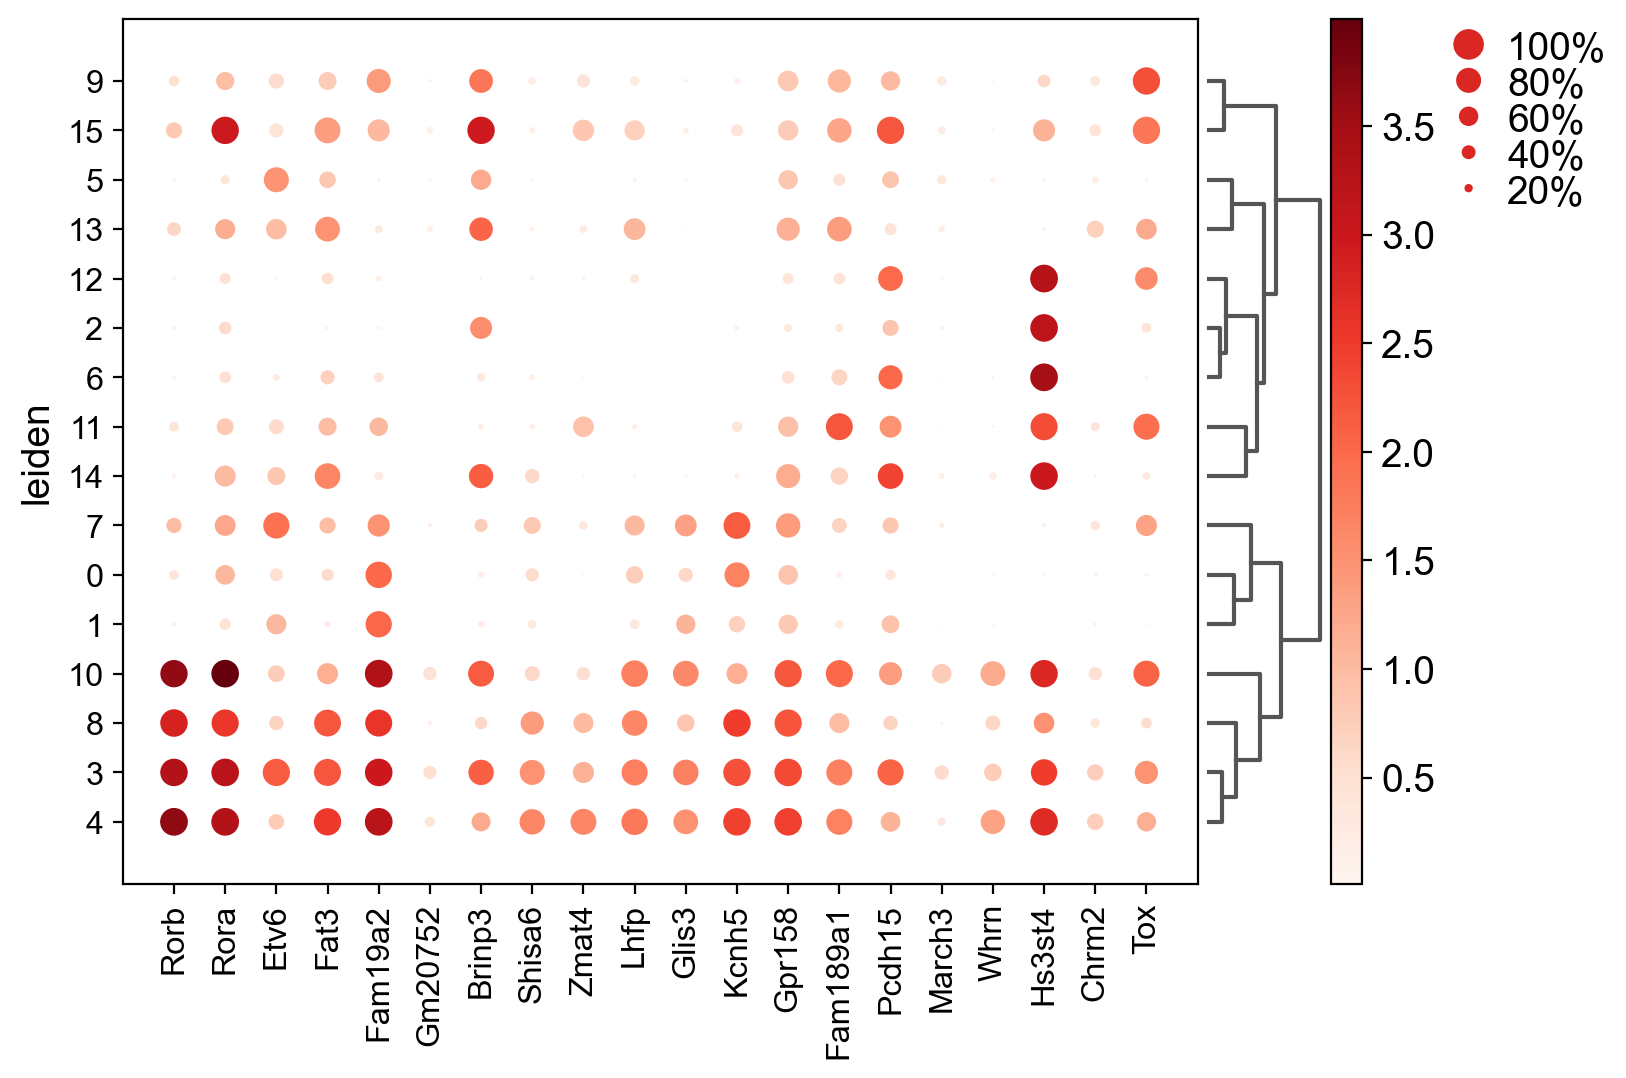

['Rorb', 'Rora', 'Etv6', 'Fat3', 'Fam19a2', 'Gm20752']


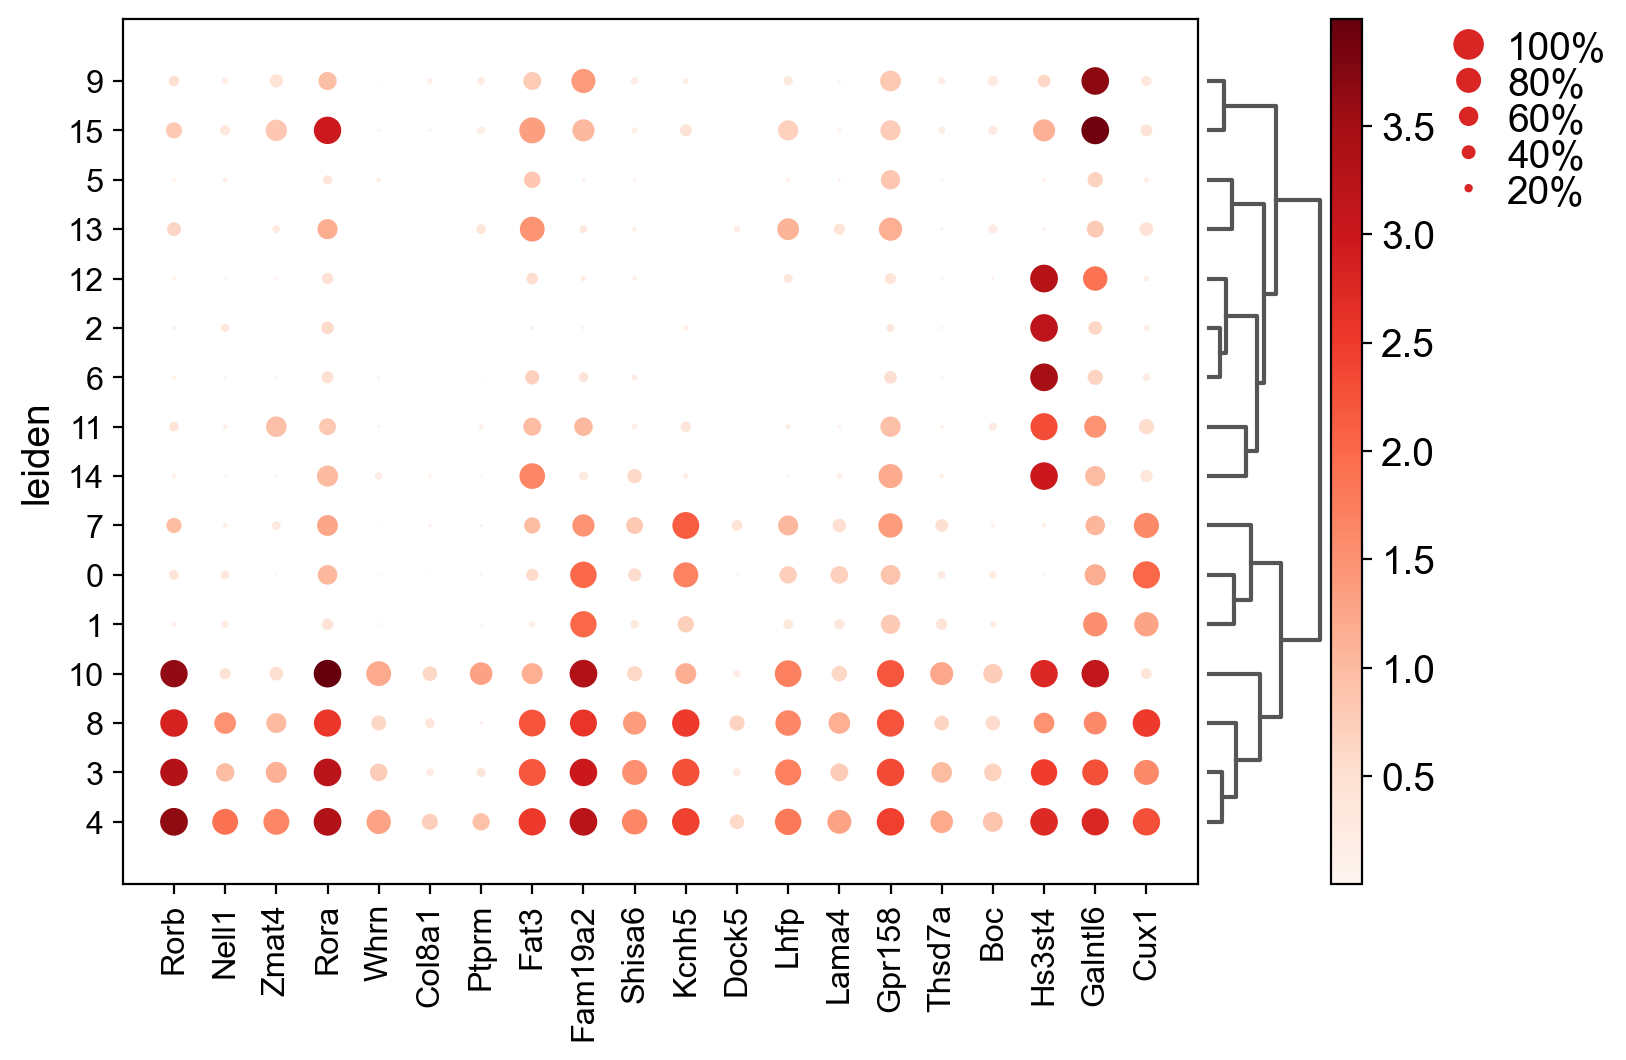

['Rorb', 'Nell1', 'Zmat4', 'Rora', 'Whrn', 'Col8a1']


In [315]:
for i in P8_glut_test.uns['dendrogram_leiden']['dendrogram_info']['ivl']:
    cluster = i
    sc.tl.rank_genes_groups(P8_glut_test, groupby='leiden', groups=[cluster], reference='rest', method='wilcoxon')
    #wilcGenes23vRest = list(P8_glut_test.uns['rank_genes_groups']['names'].astype([(cluster, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
    #if ('Malat1' in wilcGenes23vRest): del wilcGenes23vRest[wilcGenes23vRest.index('Malat1')]

    wilcLF8v14 = P8_glut_test.uns['rank_genes_groups']['logfoldchanges'].astype([(cluster, '<f8')]).view('<f8') #log fold changes ordered by score

    wilcGenes8v14_s = list(P8_glut_test.uns['rank_genes_groups']['names'].astype([(cluster, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
    wilcLF8v14_s = P8_glut_test.uns['rank_genes_groups']['logfoldchanges'].astype([(cluster, '<f8')]).view('<f8') #numpy array of logfoldchnages to be ordered lowest to highest
    wilcLF8v14_s.sort() #log fold changes from lowest to highest
    wilcGenes8v14 = [] #list of genes ordered by logfold change: low to high
    for i in wilcLF8v14_s:
        gene_idx = np.where(wilcLF8v14 == i)[0][0]
        wilcGenes8v14.append(wilcGenes8v14_s[gene_idx])
    wilcGenes8v14_correct = []
    for i in reversed(wilcGenes8v14):
        wilcGenes8v14_correct.append(i) # #list of genes ordered by logfold change high to low

    sc.pl.dotplot(P8_glut_test, wilcGenes8v14_correct[0:20], groupby='leiden', dendrogram=True)
    print(wilcGenes8v14_correct[0:6])

In [344]:
cluster_dict = {0:'L2/3_A', 1:'L2/3_B', 2:'L6CT_B', 3:'L4_B', 4:'L4_C2', 5:'L6IT_A', 
                6:'L6CT_C', 7:'L2/3_C', 8:'L4_C1',  9:'L5PT_A', 10:'L5IT/L4_A', 11:'L5NP', 
                12:'L6CT_A', 13:'L6IT_B', 14:'L6b', 15:'L5PT_B'}
cluster = []
for i in range(len(cluster_dict)): cluster.append((cluster_dict[i]))

P8_glut_test.obs['cluster'] = P8_glut_test.obs['leiden']
P8_glut_test.rename_categories(key='cluster', categories=cluster)

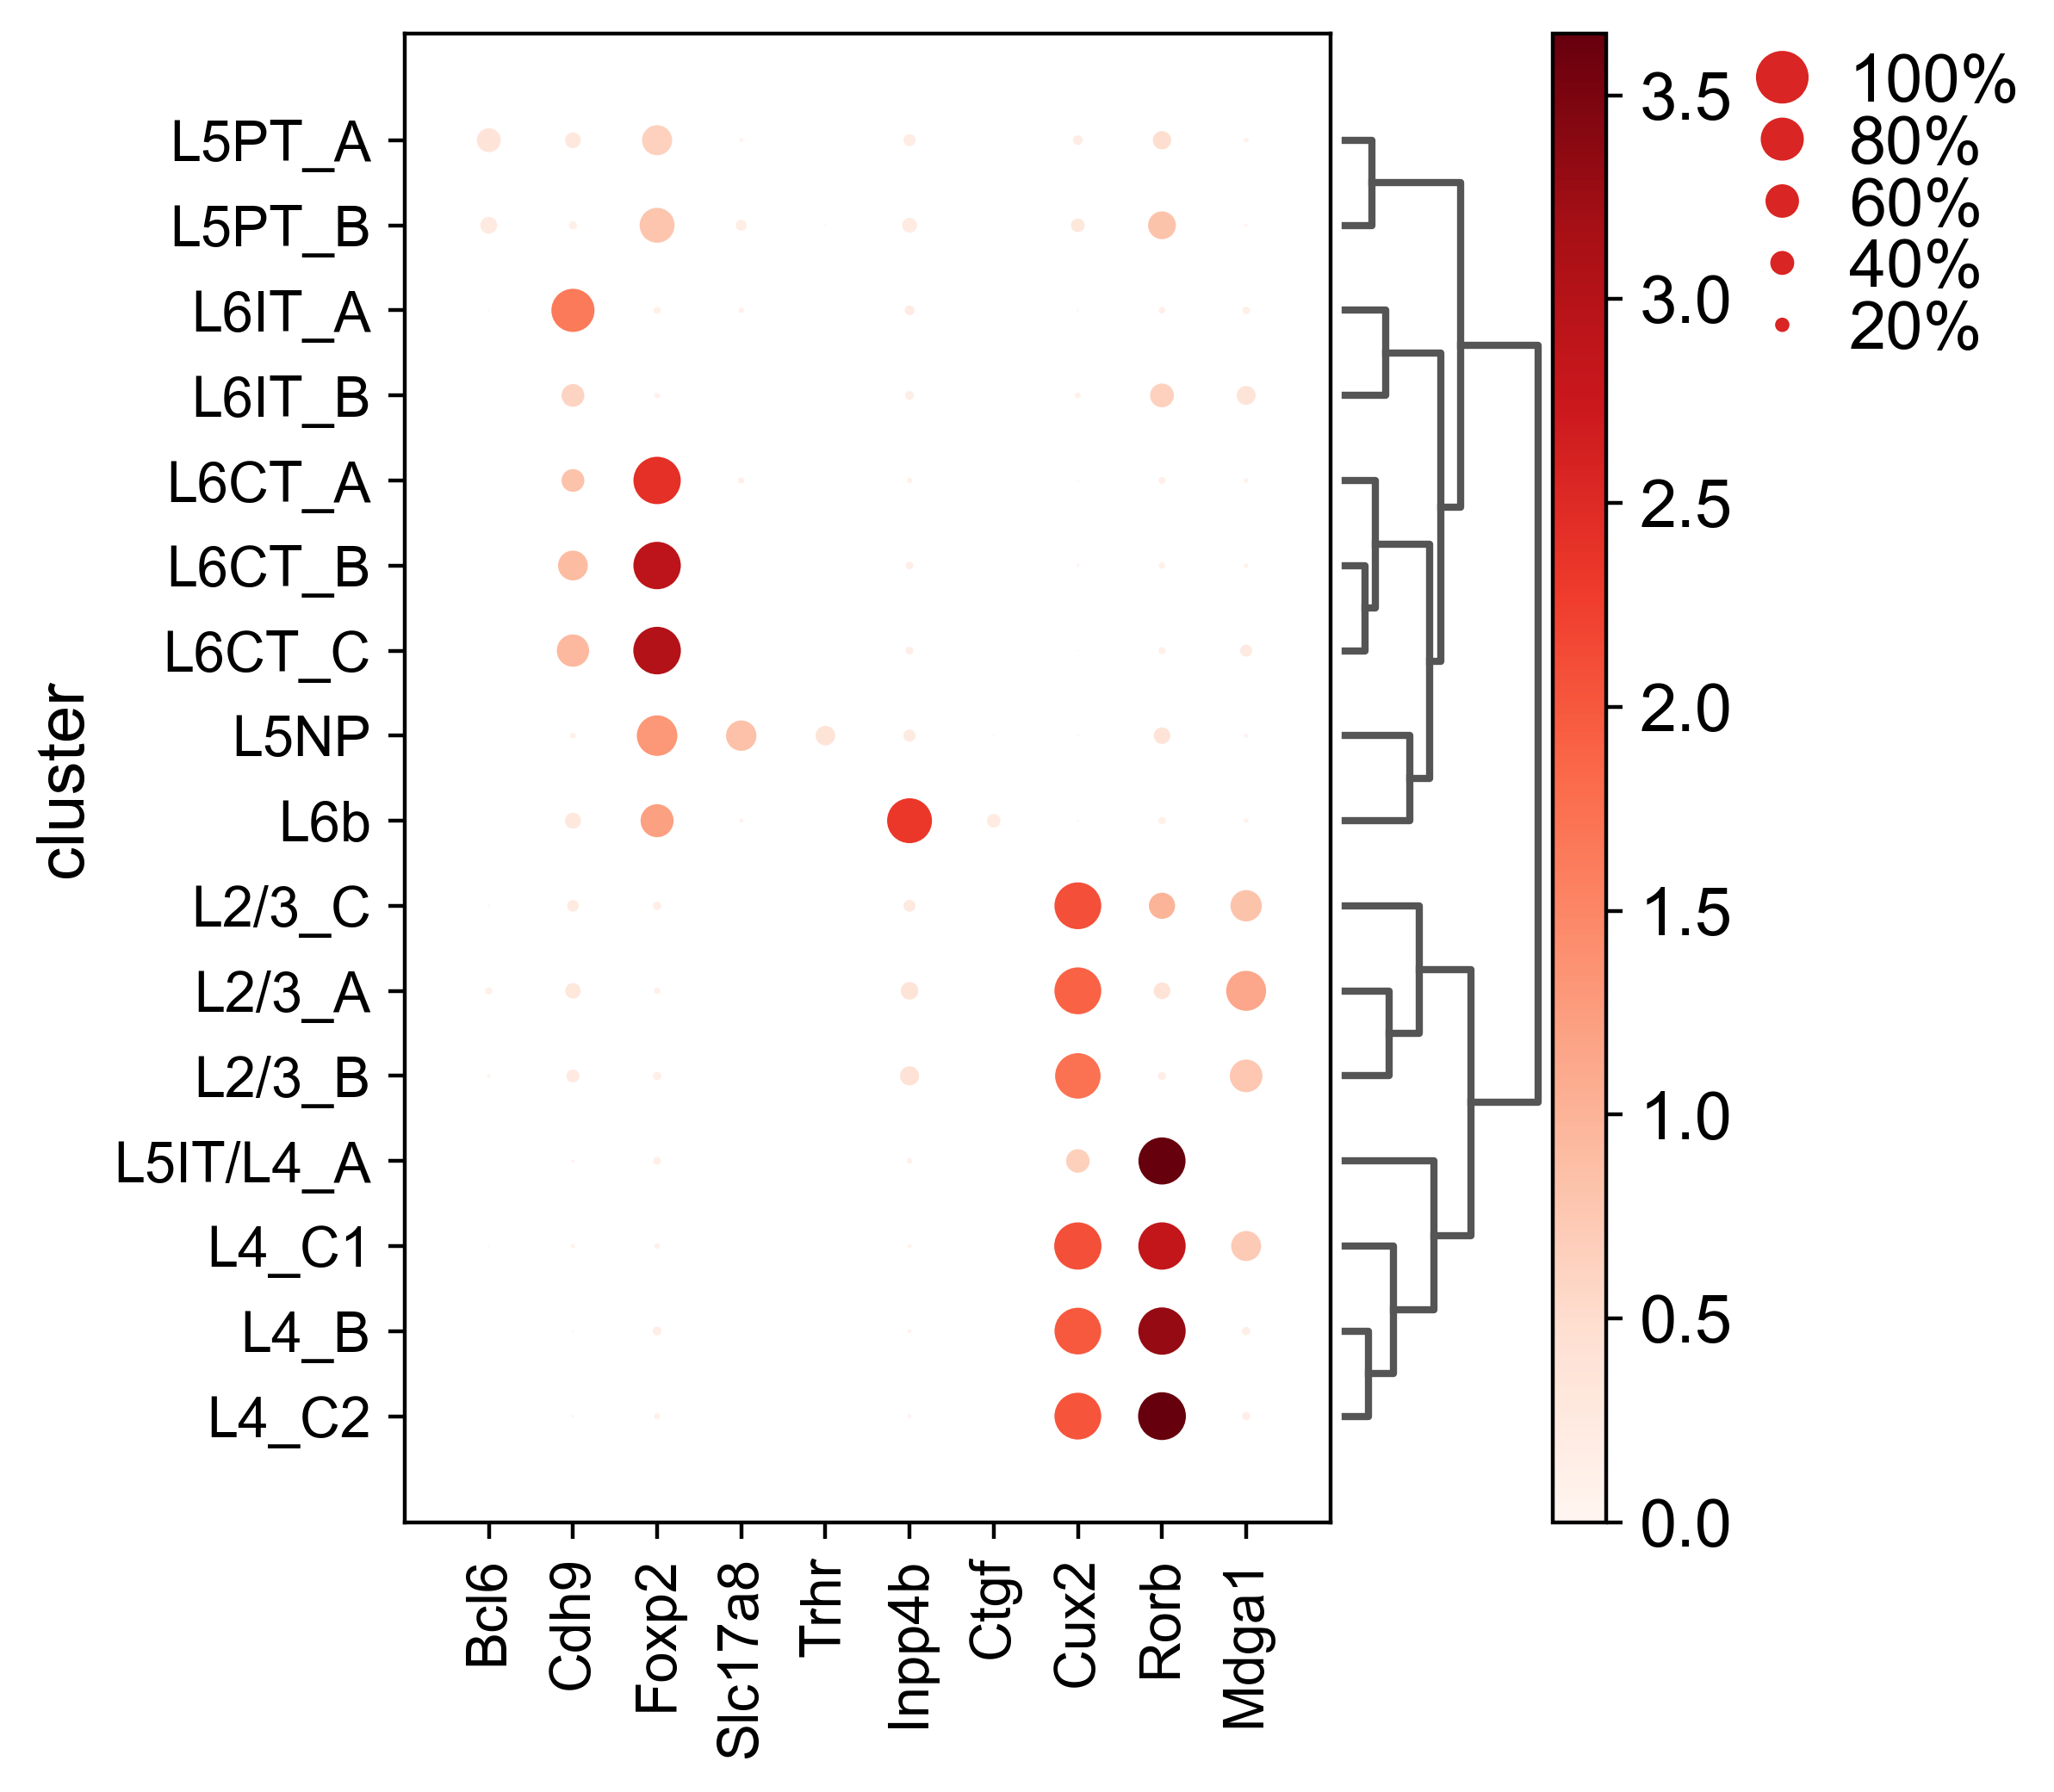

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0.8, 0.2, 0.5, 0.25])

In [14]:
sc.pl.dotplot(P8_glut_test, bias_markers, groupby='cluster', dendrogram=True)

In [348]:
P8_glut_test.write_h5ad('P8_glut08102020_use.h5ad')

In [331]:
P8_glut_test.write_h5ad('P8_glut08102020.h5ad')

In [2]:
adata = sc.read_h5ad('P8_glut08122020.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [23]:
C39 = sc.read_h5ad('C39.h5ad')

In [26]:
P8_full = adata.concatenate(C39)

In [27]:
P8_full.X = P8_full.raw.X
sc.pp.highly_variable_genes(P8_full, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs
sc.pp.scale(P8_full, max_value=10) #scale
sc.tl.pca(P8_full, svd_solver='arpack') #run PCA
sc.pp.neighbors(P8_full, n_neighbors=25, n_pcs=40) #choose 25 standard for now
sc.tl.leiden(P8_full)
sc.tl.umap(P8_full)

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True

In [36]:
P8_full_CBs = list(P8_full.obs.index)
P8_full_batch = []
for i in range(len(P8_full_CBs)):
    P8_full_batch.append(P8_full_CBs[i][19:24])
    
P8_full.obs['sample'] = P8_full.obs['batch']
P8_full.obs['sample'] = P8_full_batch

In [37]:
P8_full.obs

Age Class_broad  Doublet  \
AAACCCAGTGAGACGT-1-P8_1a-P8-P8_glut-0   P8  Excitatory    False   
AAACCCATCTGCGATA-1-P8_1a-P8-P8_glut-0   P8  Excitatory    False   
AAACGCTCACTTCATT-1-P8_1a-P8-P8_glut-0   P8  Excitatory    False   
AAACGCTGTCGTTTCC-1-P8_1a-P8-P8_glut-0   P8  Excitatory    False   
AAAGAACCAGAGTGAC-1-P8_1a-P8-P8_glut-0   P8  Excitatory    False   
...                                    ...         ...      ...   
TTGGATGCACTTGACA-1-P8_2b-P8-1          nan   Ambiguous    False   
TTGGGTATCTTAATCC-1-P8_2b-P8-1          nan   Ambiguous    False   
TTTACTGAGGACGCAT-1-P8_2b-P8-1          nan   Ambiguous    False   
TTTCATGAGTCTGTAC-1-P8_2b-P8-1          nan   Ambiguous    False   
TTTGGTTGTTAGGCTT-1-P8_2b-P8-1          nan   Ambiguous    False   

                                       Doublet Score batch  cluster leiden  \
AAACCCAGTGAGACGT-1-P8_1a-P8-P8_glut-0       0.017478     0   L6CT_B      2   
AAACCCATCTGCGATA-1-P8_1a-P8-P8_glut-0       0.020833     0   L2/3_C      7   
AAACGCTCACTTCATT-1-P8_1a-P8-P8_glut-0       0.025713     0   L2/3_B      0   
AAACGCTGTCGTTTCC-1-P8_1a-P8-P8_glut-0       0.011883     0   L6CT_C      5   
AAAGAACCAGAGTGAC-1-P8_1a-P8-P8_glut-0       0.030303     0    L4_C1      1   
...                                              ...   ...      ...    ...   
TTGGATGCACTTGACA-1-P8_2b-P8-1               0.013349     1  Ambig_6      9   
TTGGGTATCTTAATCC-1-P8_2b-P8-1               0.007108     1  Ambig_6      9   
TTTACTGAGGACGCAT-1-P8_2b-P8-1               0.024730     1  Ambig_6      9   
TTTCATGAGTCTGTAC-1-P8_2b-P8-1               0.015355     1  Ambig_6      9   
TTTGGTTGTTAGGCTT-1-P8_2b-P8-1               0.021225     1  Ambig_6      9   

                                       n_counts  n_genes  percent_mito sample  \
AAACCCAGTGAGACGT-1-P8_1a-P8-P8_glut-0   14464.0     3746      0.000346  P8_1a   
AAACCCATCTGCGATA-1-P8_1a-P8-P8_glut-0   10890.0     2716      0.000459  P8_1a   
AAACGCTCACTTCATT-1-P8_1a-P8-P8_glut-0   23384.0     4943      0.000128  P8_1a   
AAACGCTGTCGTTTCC-1-P8_1a-P8-P8_glut-0   16468.0     4146      0.000000  P8_1a   
AAAGAACCAGAGTGAC-1-P8_1a-P8-P8_glut-0   11941.0     3446      0.000251  P8_1a   
...                                         ...      ...           ...    ...   
TTGGATGCACTTGACA-1-P8_2b-P8-1            6246.0     2589      0.000000  P8_2b   
TTGGGTATCTTAATCC-1-P8_2b-P8-1            8827.0     3227      0.000113  P8_2b   
TTTACTGAGGACGCAT-1-P8_2b-P8-1            8039.0     2910      0.000000  P8_2b   
TTTCATGAGTCTGTAC-1-P8_2b-P8-1            5757.0     2426      0.000174  P8_2b   
TTTGGTTGTTAGGCTT-1-P8_2b-P8-1            7190.0     2784      0.000695  P8_2b   

                                      subclass C26_decision  
AAACCCAGTGAGACGT-1-P8_1a-P8-P8_glut-0     L6CT         keep  
AAACCCATCTGCGATA-1-P8_1a-P8-P8_glut-0     L2/3         keep  
AAACGCTCACTTCATT-1-P8_1a-P8-P8_glut-0     L2/3         keep  
AAACGCTGTCGTTTCC-1-P8_1a-P8-P8_glut-0     L6CT         keep  
AAAGAACCAGAGTGAC-1-P8_1a-P8-P8_glut-0       L4         keep  
...                                        ...          ...  
TTGGATGCACTTGACA-1-P8_2b-P8-1              nan          nan  
TTGGGTATCTTAATCC-1-P8_2b-P8-1              nan          nan  
TTTACTGAGGACGCAT-1-P8_2b-P8-1              nan          nan  
TTTCATGAGTCTGTAC-1-P8_2b-P8-1              nan          nan  
TTTGGTTGTTAGGCTT-1-P8_2b-P8-1              nan          nan  

[12175 rows x 13 columns]

In [42]:
cluster_namesP8 = []
for i in range(P8_full.shape[0]):
    if (P8_full.obs.cluster[i]=='Ambig_6'):
        cluster_namesP8.append('L5IT')
    elif (P8_full.obs.cluster[i]=='L5IT/L4_A'):
        cluster_namesP8.append('L4_A')
    elif (P8_full.obs.cluster[i]=='L4_C1'):
        cluster_namesP8.append('L4_C')
    elif (P8_full.obs.cluster[i]=='L4_C2'):
        cluster_namesP8.append('L4_C')
    else:
        cluster_namesP8.append(P8_full.obs.cluster[i])

In [43]:
P8_full.obs['cluster'] = pd.Series(cluster_namesP8, dtype="category").values

<AxesSubplot:title={'center':'P8: 12175 cells'}, xlabel='UMAP1', ylabel='UMAP2'>

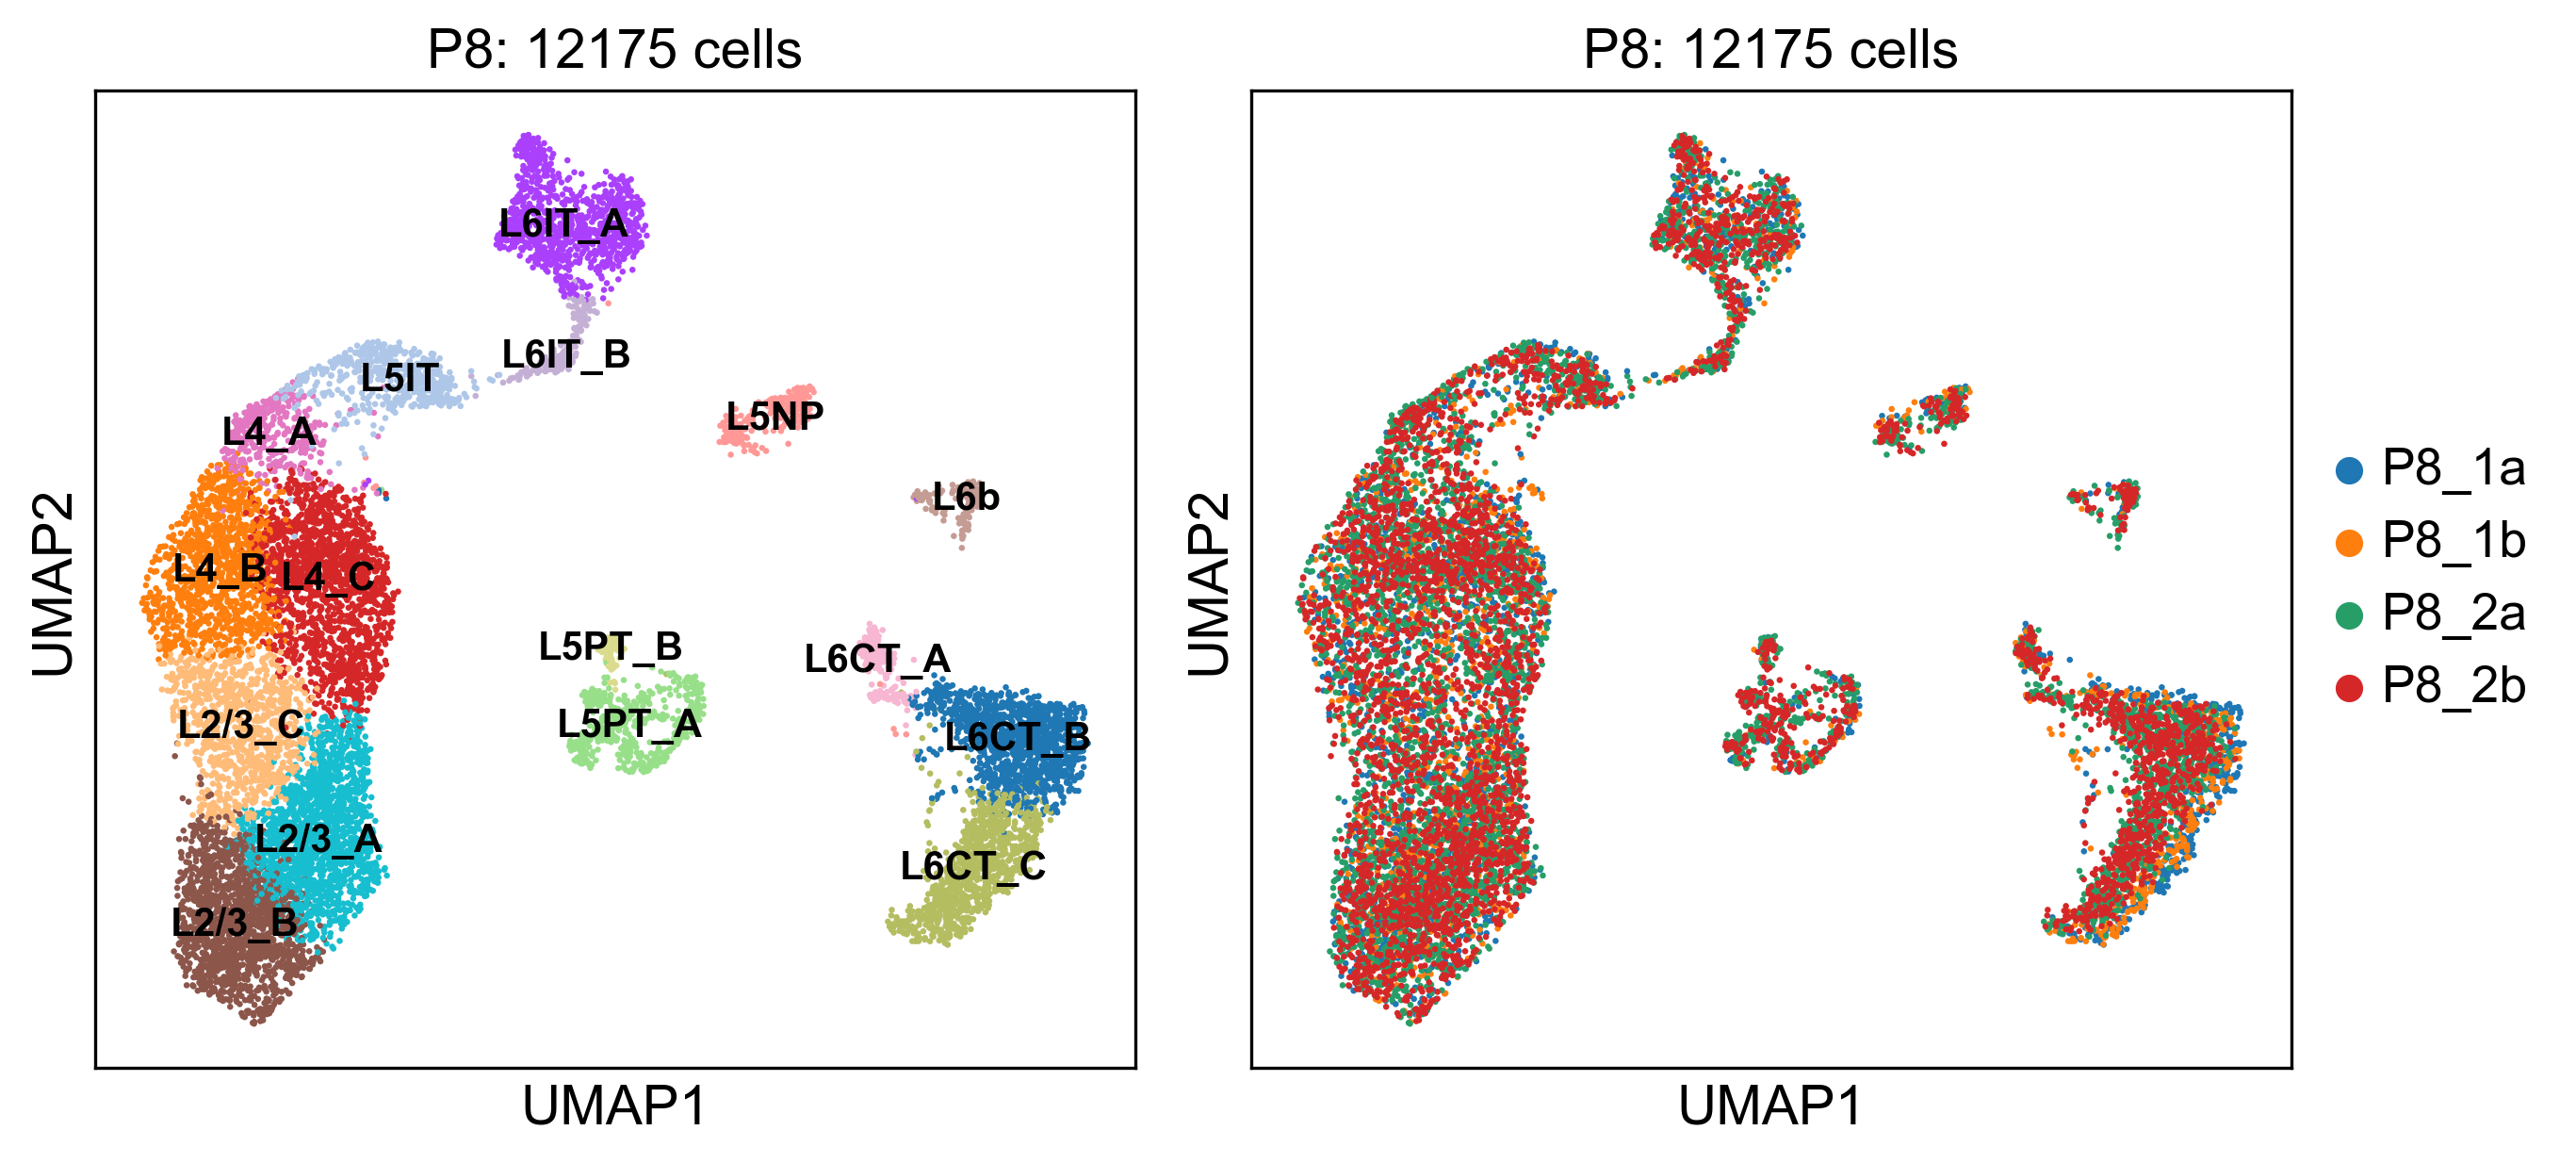

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)
sc.pl.umap(P8_full, color='cluster', legend_fontsize='10', ax=axs[0], 
           show=False, title='P8: ' + str(P8_full.shape[0]) + ' cells', frameon=True, 
          palette=('#17becf', '#8c564b', '#ffbb78', '#e377c2', '#ff7f0e', '#d62728', 
                  '#aec7e8', '#ff9896', '#98df8a', '#dbdb8d', '#f7b6d2', '#1f77b4', 
                  '#b5bd61', '#aa40fc', '#c5b0d5', '#c49c94'), legend_loc='on data')
sc.pl.umap(P8_full, color='sample', ax=axs[1], show=False, title='P8: ' + str(P8_full.shape[0]) + ' cells')

In [48]:
P8_full.write_h5ad('P8_glut08292020.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
